# Проект: Исследование работы приложения Яндекс Афиша

## Цели и задачи проекта

**Цель проекта:** Провести исследовательский анализ данных о работе приложения для выявления инсайтов об изменении пользовательских предпочтений и популярности мероприятий, а также проверки гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.

**Задачи и ход работы:**

1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Провести исследовательский анализ данных.
4. Проверить статистические гипотезы.
5. Сформулировать выводы по проведённому анализу.

**Импортируем необходимые библиотеки:**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from scipy.stats import ttest_ind
from statsmodels.stats.power import NormalIndPower

### Шаг 1. Загрузка данных и знакомство с ними

**Названия файлов:**
- `final_tickets_orders_df.csv`
- `final_tickets_events_df.csv`
- `final_tickets_tenge_df.csv`

**Описание данных:**
1. **Таблица `final_tickets_orders_df`:** включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных:
 - `order_id` — уникальный идентификатор заказа.
 - `user_id` — уникальный идентификатор пользователя.
 - `created_dt_msk` — дата создания заказа (московское время).
 - `created_ts_msk` — дата и время создания заказа (московское время).
 - `event_id` — идентификатор мероприятия из таблицы events.
 - `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
 - `age_limit` — возрастное ограничение мероприятия.
 - `currency_code` — валюта оплаты, например rub для российских рублей.
 - `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
 - `revenue` — выручка от заказа.
 - `service_name` — название билетного оператора.
 - `tickets_count` — количество купленных билетов.
 - `total` — общая сумма заказа.
 - `days_since_prev` - количество дней с предыдущей покупуи.
 
 
2. **Таблица ` final_tickets_events_df`:** содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия:
 - `event_id` — уникальный идентификатор мероприятия.
 - `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
 - `event_type_description` — описание типа мероприятия.
 - `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
 - `organizers` — организаторы мероприятия.
 - `region_name` — название региона.
 - `city_name` — название города.
 - `venue_id` — уникальный идентификатор площадки.
 - `venue_name` — название площадки.
 - `venue_address` — адрес площадки.
 
 
3. **Таблица `final_tickets_tenge_df`:** содержит информацию о курсе тенге к российскому рублю за 2024 год (Значения в рублях представлено для 100 тенге):
 - `nominal` — номинал (100 тенге).
 - `data` — дата.
 - `curs` — курс тенге к рублю.
 - `cdx` — обозначение валюты (kzt).

In [2]:
#Загрузка данных
final_tickets_orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
final_tickets_events_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
final_tickets_tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

#### Общая информация о данных:

In [3]:
display("Датасет final_tickets_orders_df:")
display(final_tickets_orders_df.info())
display(final_tickets_orders_df.head())

'Датасет final_tickets_orders_df:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

None

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [4]:
display("Датасет final_tickets_events_df:")
display(final_tickets_events_df.info())
display(final_tickets_events_df.head())

'Датасет final_tickets_events_df:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


None

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [5]:
display("Датасет final_tickets_tenge_df:")
display(final_tickets_tenge_df.info())
display(final_tickets_tenge_df.head())

'Датасет final_tickets_tenge_df:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


None

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [6]:
na = final_tickets_orders_df['days_since_prev'].isna().sum()
na_proc = round(final_tickets_orders_df['days_since_prev'].isna().sum() / final_tickets_orders_df.shape[0] * 100, 2)

#### Промежуточные выводы:

В датасете `final_tickets_orders_df` 14 параметров и 290 849 записей. Пропуски содержатся только в переменной `days_since_prev` (они означают, что пользователь не совершил повторную покупку в исследуемом периоде).

In [7]:
print(f'Количество пропусков в перемнной days_since_prev: {na}. В относительном выражении: {na_proc}%')

Количество пропусков в перемнной days_since_prev: 21940. В относительном выражении: 7.54%


Для более корректтного отображения данных предлагается перевести некоторые данные к более соответствующим типам:
1. Поля `created_dt_msk` и `created_ts_msk`: к типу **datetime**.
2. Поля `order_id`, `event_id`, `age_limit`, `tickets_count`, `revenue` и `total`: снизить размерность.
3. Поле `days_since_prev`: поставить значение-индикатор **-1** вместо пропусков и привести к типу **integer**.

В датасете `final_tickets_events_df` 11 параметров и 22 427 наблюдений, пропуски отсутствуют. Предлагается осуществить следующие изменения в типах данных:
1. Поля `event_id`, `city_id`и `venue_id`: снизить размерность.

В датасете `final_tickets_tenge_df` 4 параметра и 357 наблюдений, пропуски отсутствуют. Предлагается осуществить следующие изменения в типах данных:
1. Поля `nominal` и `curs`: снизить размерность.
2. Поле `data`: к типу **datetime**.

#### Приведем данные к соответствующим типам:

In [8]:
#Датасет final_tickets_orders_df

final_tickets_orders_df['created_dt_msk'] = pd.to_datetime(final_tickets_orders_df['created_dt_msk'], format='%Y/%m/%d')
final_tickets_orders_df['created_ts_msk'] = pd.to_datetime(final_tickets_orders_df['created_ts_msk'], 
                                                           format='%Y/%m/%d %H:%M:%S')

for i in['order_id', 'event_id', 'age_limit', 'tickets_count']:
    final_tickets_orders_df[i] = pd.to_numeric(final_tickets_orders_df[i], downcast = 'integer')

final_tickets_orders_df['revenue'] = pd.to_numeric(final_tickets_orders_df['revenue'], downcast = 'float')
final_tickets_orders_df['total'] = pd.to_numeric(final_tickets_orders_df['total'], downcast = 'float')

#Поставим значение-индикатор -1 в поле days_since_prev
final_tickets_orders_df['days_since_prev'] = final_tickets_orders_df['days_since_prev'].fillna(-1)
final_tickets_orders_df['days_since_prev'] = pd.to_numeric(final_tickets_orders_df['days_since_prev'], downcast = 'integer')

In [9]:
#Датасет final_tickets_events_df

for i in['event_id', 'city_id', 'venue_id']:
    final_tickets_events_df[i] = pd.to_numeric(final_tickets_events_df[i], downcast = 'integer')

In [10]:
#Датасет final_tickets_tenge_df

final_tickets_tenge_df['nominal'] = pd.to_numeric(final_tickets_tenge_df['nominal'], downcast = 'integer')
final_tickets_tenge_df['curs'] = pd.to_numeric(final_tickets_tenge_df['curs'], downcast = 'float')

final_tickets_tenge_df['data'] = pd.to_datetime(final_tickets_tenge_df['data'], format='%Y/%m/%d')

In [11]:
display(final_tickets_orders_df.info())
display(final_tickets_events_df.info())
display(final_tickets_tenge_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290849 non-null  int32         
 1   user_id                290849 non-null  object        
 2   created_dt_msk         290849 non-null  datetime64[ns]
 3   created_ts_msk         290849 non-null  datetime64[ns]
 4   event_id               290849 non-null  int32         
 5   cinema_circuit         290849 non-null  object        
 6   age_limit              290849 non-null  int8          
 7   currency_code          290849 non-null  object        
 8   device_type_canonical  290849 non-null  object        
 9   revenue                290849 non-null  float32       
 10  service_name           290849 non-null  object        
 11  tickets_count          290849 non-null  int8          
 12  total                  290849 non-null  floa

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int32 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int32 
 8   venue_id                22427 non-null  int16 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int16(1), int32(2), object(8)
memory usage: 1.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int8          
 2   curs     357 non-null    float32       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float32(1), int8(1), object(1)
memory usage: 7.4+ KB


None

В итоге удалось привести данные к оптимальному типу данных и избавиться от пропусков, поставив заглушку в поле `days_since_prev`.

### Шаг 2. Предобработка данных и подготовка их к исследованию

#### Создадим единый датасет для последующего анализа:

In [12]:
df_merged_left = (final_tickets_orders_df.merge(final_tickets_events_df, on = 'event_id', how = 'left')
                          .merge(final_tickets_tenge_df, left_on = 'created_dt_msk', right_on = 'data', how = 'left'))

In [13]:
df_merged_left.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290849 non-null  int32         
 1   user_id                 290849 non-null  object        
 2   created_dt_msk          290849 non-null  datetime64[ns]
 3   created_ts_msk          290849 non-null  datetime64[ns]
 4   event_id                290849 non-null  int32         
 5   cinema_circuit          290849 non-null  object        
 6   age_limit               290849 non-null  int8          
 7   currency_code           290849 non-null  object        
 8   device_type_canonical   290849 non-null  object        
 9   revenue                 290849 non-null  float32       
 10  service_name            290849 non-null  object        
 11  tickets_count           290849 non-null  int8          
 12  total                   290849

In [14]:
display(df_merged_left[df_merged_left['event_name'].isna()].head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
62,6493246,002ec276eee9b0b,2024-10-14,2024-10-14 16:27:53,533222,нет,6,rub,mobile,78.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-10-14,100,19.5723,kzt
63,6493275,002ec276eee9b0b,2024-10-14,2024-10-14 16:22:38,533222,нет,6,rub,mobile,78.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-10-14,100,19.5723,kzt
64,6493304,002ec276eee9b0b,2024-10-14,2024-10-14 16:29:20,533222,нет,6,rub,mobile,118.120003,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-10-14,100,19.5723,kzt
237,8272280,00da083909dc06b,2024-06-07,2024-06-07 17:50:50,530296,нет,18,rub,mobile,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-06-07,100,19.7843,kzt
238,8272512,00da083909dc06b,2024-06-07,2024-06-07 17:49:16,530296,нет,18,rub,mobile,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-06-07,100,19.7843,kzt


Заметим, что после объединения датасетов типом `left` в полях изначальной таблицы `final_tickets_events_df` образовались пропуски. Это означает, что в таблице `final_tickets_orders_df` находились `event_id` с несуществующей информацией о мероприятиях, поэтому удалим эти наблюдения, объединив датафреймы типом `inner`:

In [15]:
df_merged = (final_tickets_orders_df.merge(final_tickets_events_df, on = 'event_id')
                          .merge(final_tickets_tenge_df, left_on = 'created_dt_msk', right_on = 'data', how = 'left'))

In [16]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int32         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int32         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int8          
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float32       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int8          
 12  total                   290611

In [17]:
df_merged.shape_zero = df_merged.shape[0]
deleted_join = final_tickets_orders_df.shape[0] - df_merged.shape_zero
deleted_join_proc = round(deleted_join / final_tickets_orders_df.shape[0]*100, 2)
print(f'При объединении таблиц по причине отсутствия данных было удалено {deleted_join} наблюдений,', end= ' ')
print(f'что составляет {deleted_join_proc}% от изначального датасета')

При объединении таблиц по причине отсутствия данных было удалено 238 наблюдений, что составляет 0.08% от изначального датасета


#### Рассмотрим категориальные данные:

In [18]:
for i in['cinema_circuit', 'currency_code', 'device_type_canonical', 'service_name', 'event_type_description', 
         'event_type_main', 'organizers', 'region_name', 'city_name', 'venue_name', 'venue_address', 'cdx']:
    print(f'Уникальные значения поля {i}:')
    display(df_merged[i].unique())
    display(df_merged[i].nunique())

Уникальные значения поля cinema_circuit:


array(['нет', 'Другое', 'КиноСити', 'Киномакс', 'Москино', 'ЦентрФильм'],
      dtype=object)

6

Уникальные значения поля currency_code:


array(['rub', 'kzt'], dtype=object)

2

Уникальные значения поля device_type_canonical:


array(['mobile', 'desktop'], dtype=object)

2

Уникальные значения поля service_name:


array(['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!',
       'Билеты без проблем', 'Билеты в руки', 'Облачко', 'Дом культуры',
       'Весь в билетах', 'Лучшие билеты', 'Прачечная', 'Выступления.ру',
       'Мир касс', 'Тебе билет!', 'Быстробилет', 'Яблоко', 'Show_ticket',
       'Городской дом культуры', 'Билет по телефону', 'Crazy ticket!',
       'Росбилет', 'Шоу начинается!', 'Цвет и билет', 'Быстрый кассир',
       'Восьмёрка', 'Телебилет', 'Реестр', 'КарандашРУ', 'Радио ticket',
       'Дырокол', 'Вперёд!', 'Кино билет', 'Зе Бест!', 'Тех билет',
       'Лимоны', 'Билеты в интернете'], dtype=object)

36

Уникальные значения поля event_type_description:


array(['спектакль', 'событие', 'цирковое шоу', 'выставка', 'шоу',
       'концерт', 'спорт', 'мюзикл', 'фестиваль', 'ёлка', 'балет',
       'спортивное мероприятие', 'опера', 'музыкальный спектакль',
       'кукольный спектакль', 'оперетта', 'снегурочка', 'рок-мюзикл',
       'экскурсия', 'подарок'], dtype=object)

20

Уникальные значения поля event_type_main:


array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

7

Уникальные значения поля organizers:


array(['№3322', '№4850', '№1540', ..., '№1161', '№3497', '№1904'],
      dtype=object)

4293

Уникальные значения поля region_name:


array(['Каменевский регион', 'Североярская область', 'Озернинский край',
       'Лугоградская область', 'Поленовский край', 'Широковская область',
       'Медовская область', 'Златопольский округ', 'Малиновоярский округ',
       'Яблоневская область', 'Ветренский регион', 'Боровлянский край',
       'Крутоводская область', 'Ягодиновская область',
       'Серебряноярский округ', 'Лесодальний край', 'Верхоречная область',
       'Горицветская область', 'Речиновская область', 'Травиницкий округ',
       'Сосновская область', 'Серебринская область', 'Травяная область',
       'Каменноярский край', 'Солнечноземская область',
       'Светополянский округ', 'Заречная область', 'Ручейковский край',
       'Глиногорская область', 'Тепляковская область',
       'Каменноозёрный край', 'Солнечнореченская область',
       'Зоринский регион', 'Берёзовская область', 'Лесостепной край',
       'Малиновая область', 'Синегорский регион', 'Луговая область',
       'Шанырский регион', 'Каменополянский окр

81

Уникальные значения поля city_name:


array(['Глиногорск', 'Озёрск', 'Родниковецк', 'Кристалевск',
       'Дальнозолотск', 'Радужнополье', 'Радужсвет', 'Кумсай',
       'Верховино', 'Светополье', 'Кокжар', 'Каменский', 'Лесоярич',
       'Никольянов', 'Речинцево', 'Лесозолотск', 'Дальнозерск',
       'Серебрянка', 'Островецк', 'Родниковец', 'Дальнесветск',
       'Луговаярово', 'Ягодиновка', 'Дальнополин', 'Солчелуг', 'Озёрчане',
       'Серебровино', 'Лесоярово', 'Глинополье', 'Глиноград',
       'Дальнесветин', 'Северополье', 'Теплоозеро', 'Горнодолинск',
       'Ордакент', 'Озёрово', 'Луговинск', 'Лугоград', 'Златопольск',
       'Крутовинск', 'Сарыжар', 'Сосновечин', 'Тихоярск', 'Яблонецк',
       'Жаркентай', 'Широковка', 'Синеводов', 'Синеводск', 'Тихосветск',
       'Радужанов', 'Глиногорь', 'Каменосветск', 'Родниковск',
       'Травогород', 'Глинянск', 'Радужинск', 'Поляногорье',
       'Дальнолесье', 'Ручейник', 'Ключеград', 'Ключеводск', 'Поленовино',
       'Речичанск', 'Ключевополье', 'Шаныртау', 'Дальнесоснов'

352

Уникальные значения поля venue_name:


array(['Сценический центр "Деталь" Групп',
       'Музыкальная школа для детей "Аккаунт" Лтд',
       'Училище искусств "Нирвана" Инк', ...,
       'Университет искусств "Прогресс" Групп',
       'Творческая ярмарка "График" Инк', 'Школа музыки "Парадигма" Лтд'],
      dtype=object)

3217

Уникальные значения поля venue_address:


array(['алл. Машиностроителей, д. 19 стр. 6', 'алл. Шмидта, д. 9 стр. 4',
       'алл. Юбилейная, д. 5/6', ..., 'ш. Безымянное, д. 6',
       'алл. Тепличная, д. 4/1', 'пр. Сплавный, д. 236 к. 918'],
      dtype=object)

3225

Уникальные значения поля cdx:


array(['kzt'], dtype=object)

1

На первый взгляд в категориальных данных отсутствуют неявные дубликаты и  значения-индикаторы, указывающие на пропуски.

#### Рассмотрим количественные данные:

In [19]:
# Возрастной лимит мероприятий
df_age = df_merged.groupby('age_limit')['order_id'].count().reset_index().sort_values(by = 'order_id', ascending=False)
df_age['limit_share'] =  round(df_age['order_id'] / df_merged.shape[0], 2)
display(df_age)

,age_limit,order_id,limit_share
3,16,78556,0.27
2,12,62474,0.21
0,0,61487,0.21
1,6,52161,0.18
4,18,35933,0.12


Наименьшую долю **12%** занимают мероприятия с возрастным ограничением **18+**, наибольшую долю **27%** - мероприятия **16+**.

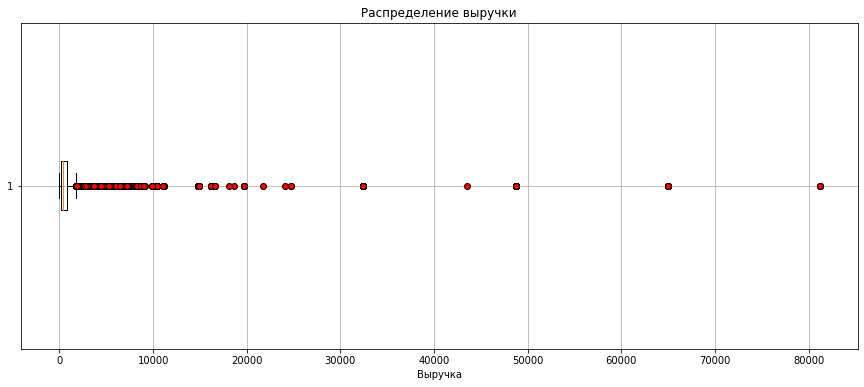

In [20]:
# Выручка в рублях
rub_orders = df_merged[df_merged['currency_code'] == 'rub']

plt.figure(figsize=(15, 6))

plt.boxplot(rub_orders['revenue'],
vert=False,
flierprops=dict(markerfacecolor='r', marker='o'))
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.grid(True)

plt.show()

Основа данных располагается ближе к нулю, присутствует множество выбросов в правой части, рсммотрим до какого значения находятся 99% данных:

In [21]:
outline_rub = rub_orders['revenue'].quantile(0.99)
outline_rub

2570.800048828125

In [22]:
# Посчитаем количество данных за порогом 99 процентиля:
outline_rub_count = rub_orders.loc[rub_orders['revenue'] >= outline_rub].shape[0]
outline_rub_count

2857

In [23]:
# Удалим выбросы из данных в рублях
rub_orders = rub_orders.loc[rub_orders['revenue'] < outline_rub]

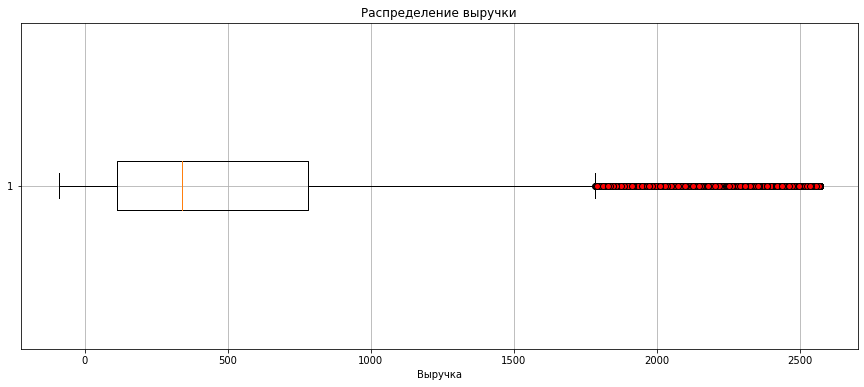

In [24]:
plt.figure(figsize=(15, 6))

plt.boxplot(rub_orders['revenue'],
vert=False,
flierprops=dict(markerfacecolor='r', marker='o'))
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.grid(True)

plt.show()

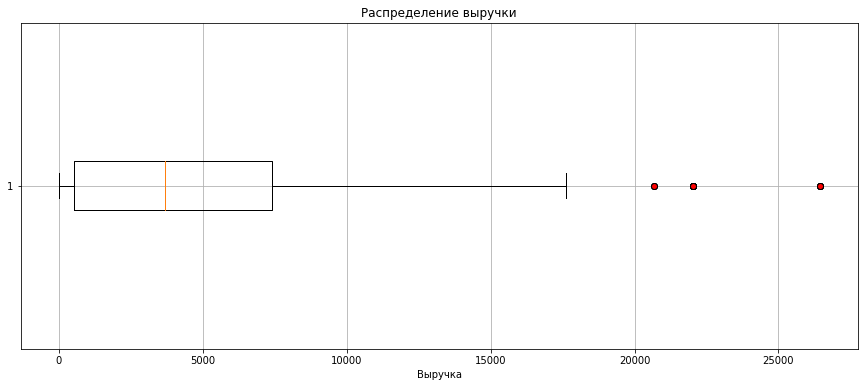

In [25]:
# Выручка в тенге
kzt_orders = df_merged[df_merged['currency_code'] == 'kzt']

plt.figure(figsize=(15, 6))

plt.boxplot(kzt_orders['revenue'],
vert=False,
flierprops=dict(markerfacecolor='r', marker='o'))
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.grid(True)

plt.show()

In [26]:
outline_kzt = kzt_orders['revenue'].quantile(0.99)
outline_kzt

17617.240234375

In [27]:
# Посчитаем количество данных за порогом 99 процентиля:
outline_kzt_count = kzt_orders.loc[kzt_orders['revenue'] >= outline_kzt].shape[0]
outline_kzt_count

225

In [28]:
# Удалим выбросы из данных в тенге
kzt_orders = kzt_orders.loc[kzt_orders['revenue'] < outline_kzt]

In [29]:
rub_orders['revenue'].describe()

count    282685.000000
mean        510.392944
std         500.127838
min         -90.760002
25%         112.089996
50%         340.600006
75%         781.719971
max        2569.610107
Name: revenue, dtype: float64

In [30]:
kzt_orders['revenue'].describe()

count     4844.000000
mean      4378.842773
std       4072.645264
min          0.000000
25%        486.029999
50%       3698.830078
75%       7076.240234
max      17230.320312
Name: revenue, dtype: float64

Заметим, что для данных в рублях в поле выручки присутствуют отрицательные значения. Посмотрим на них:

In [31]:
under_zero_count = rub_orders[rub_orders['revenue'] < 0].shape[0]
display(under_zero_count)
display(rub_orders[rub_orders['revenue'] < 0].head())

381

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
24218,1594653,00eb3dc9baa1543,2024-06-29,2024-06-29 15:01:43,538650,нет,0,rub,mobile,-2.37,...,Берёзовская область,Златопольск,74,4593,"Центр традиционных ремесел ""Путь"" Инк","алл. Чайковского, д. 6 к. 691",2024-06-29,100,18.419800,kzt
24219,6620527,06727636bf2f465,2024-06-30,2024-06-30 05:40:34,538650,нет,0,rub,mobile,-1.58,...,Берёзовская область,Златопольск,74,4593,"Центр традиционных ремесел ""Путь"" Инк","алл. Чайковского, д. 6 к. 691",2024-06-30,100,18.419800,kzt
24220,6444729,0beb8fc0c0a9ce1,2024-06-26,2024-06-26 03:22:06,538650,нет,0,rub,mobile,-1.58,...,Берёзовская область,Златопольск,74,4593,"Центр традиционных ремесел ""Путь"" Инк","алл. Чайковского, д. 6 к. 691",2024-06-26,100,18.757999,kzt
24221,3015711,1783ebcbcdf41b1,2024-06-26,2024-06-26 06:11:20,538650,нет,0,rub,mobile,-2.37,...,Берёзовская область,Златопольск,74,4593,"Центр традиционных ремесел ""Путь"" Инк","алл. Чайковского, д. 6 к. 691",2024-06-26,100,18.757999,kzt
24222,115537,1e3795ecb8bb655,2024-06-30,2024-06-30 07:15:20,538650,нет,0,rub,mobile,-1.58,...,Берёзовская область,Златопольск,74,4593,"Центр традиционных ремесел ""Путь"" Инк","алл. Чайковского, д. 6 к. 691",2024-06-30,100,18.419800,kzt


Так как мы используем предположение, что выручка с заказа формируется от процента за использование площадки Яндекс Афиша и сервисного сбора и с учетом того, что в техническом задании отсутствует информация о возможности получения отрицательной выручки, удалим эти данные из датасета:

In [32]:
rub_orders = rub_orders.loc[rub_orders['revenue'] >= 0]

In [33]:
rub_orders['revenue'].describe()

count    282304.000000
mean        511.085083
std         500.109894
min           0.000000
25%         112.980003
50%         341.549988
75%         782.169983
max        2569.610107
Name: revenue, dtype: float64

Удалим данные из общего датасета:

In [34]:
df_merged = df_merged.loc[((df_merged['currency_code'] == 'rub') & (df_merged['revenue'] < outline_rub) 
                          & (df_merged['revenue'] >=0)) | (df_merged['currency_code'] == 'kzt') 
                          & (df_merged['revenue'] < outline_kzt)]

In [35]:
print(f'В итоге, после удаления 3 463 выбросов поля revenue в данных осталось {df_merged.shape[0]} наблюдений.')

В итоге, после удаления 3 463 выбросов поля revenue в данных осталось 287148 наблюдений.


Рассмотрим распределение количества билетов в заказе:

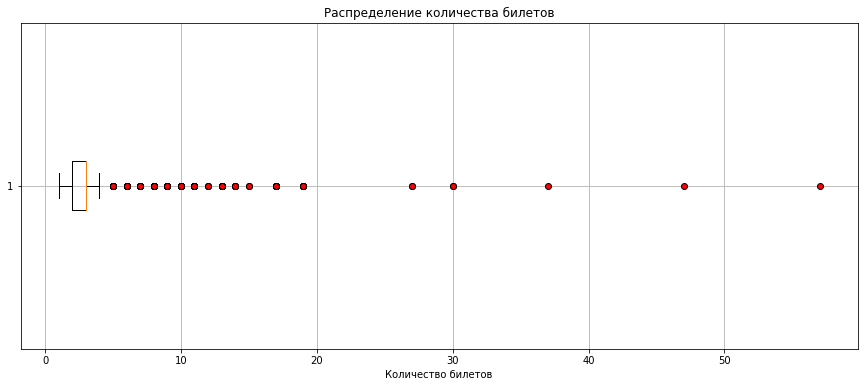

In [36]:
plt.figure(figsize=(15, 6))

plt.boxplot(df_merged['tickets_count'],
vert=False,
flierprops=dict(markerfacecolor='r', marker='o'))
plt.title('Распределение количества билетов')
plt.xlabel('Количество билетов')
plt.grid(True)

plt.show()

In [37]:
df_merged['tickets_count'].describe()

count    287148.000000
mean          2.739936
std           1.162401
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

В среднем пользователи покупали три билета в заказе, однако существует небольшое количество данных, в которых количество билетов превышает 10 шт, а максимальное значение - 57 билетов.

Рассмотрим распределение общей суммы заказа:

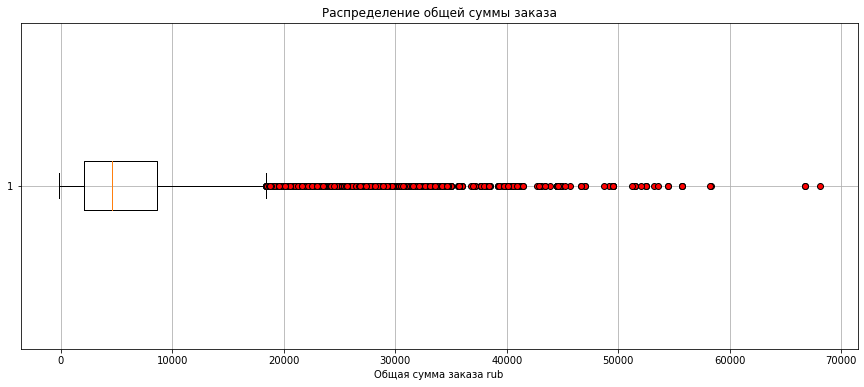

In [38]:
plt.figure(figsize=(15, 6))

plt.boxplot(rub_orders['total'],
vert=False,
flierprops=dict(markerfacecolor='r', marker='o'))
plt.title('Распределение общей суммы заказа')
plt.xlabel('Общая сумма заказа rub')
plt.grid(True)

plt.show()

In [39]:
rub_orders['total'].describe()

count    282304.000000
mean       6017.723145
std        5127.943848
min        -184.169998
25%        2111.199951
50%        4607.290039
75%        8646.620117
max       68049.593750
Name: total, dtype: float64

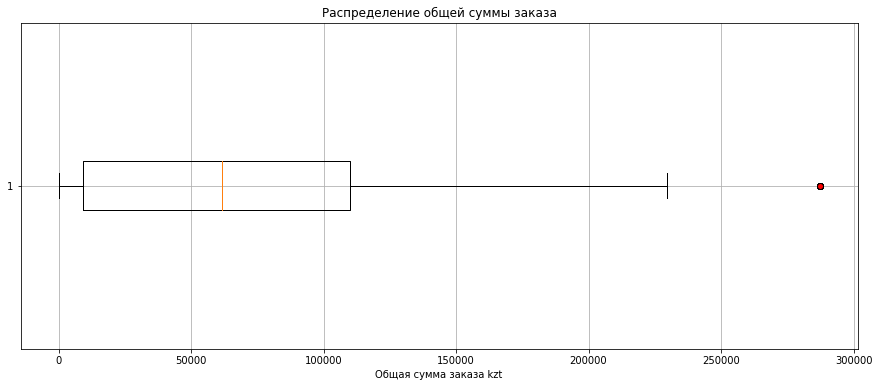

In [40]:
plt.figure(figsize=(15, 6))

plt.boxplot(kzt_orders['total'],
vert=False,
flierprops=dict(markerfacecolor='r', marker='o'))
plt.title('Распределение общей суммы заказа')
plt.xlabel('Общая сумма заказа kzt')
plt.grid(True)

plt.show()

In [41]:
kzt_orders['total'].describe()

count      4844.000000
mean      68073.460938
std       60471.539062
min           0.000000
25%        9258.150391
50%       61647.160156
75%      110107.773438
max      287172.093750
Name: total, dtype: float64

Видим, что в заказах в рублях также присутствуют отрицательные значения поля `total`, удалим их из датасета:

In [42]:
# Количество данных с отрицательной суммой заказа
total_under_zero = rub_orders[rub_orders['total'] < 0].shape[0]
total_under_zero

2

In [43]:
df_merged = df_merged.loc[df_merged['total'] >= 0]

Рассмотрим количество дней с предыдущей покупки пользователя (без учета значения-индикатора `-1`):

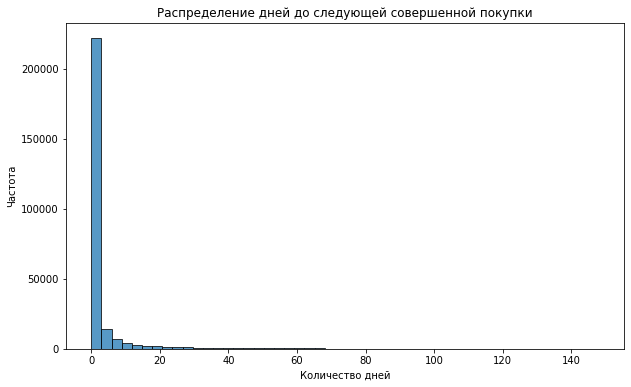

In [44]:
plt.figure(figsize=(10, 6))

df_merged[df_merged['days_since_prev'] != -1]['days_since_prev'].plot(
                kind='hist',
                bins=50, 
                alpha=0.75,
                edgecolor='black',
                rot=0)

plt.title('Распределение дней до следующей совершенной покупки')
plt.xlabel('Количество дней')
plt.ylabel('Частота')

plt.show()

In [45]:
df_merged[df_merged['days_since_prev'] != -1]['days_since_prev'].describe()

count    265493.000000
mean          3.224292
std          11.361541
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         148.000000
Name: days_since_prev, dtype: float64

In [46]:
z_since_prev = round(df_merged[df_merged['days_since_prev'] == 0]['days_since_prev'].shape[0] / 
df_merged[df_merged['days_since_prev'] != -1]['days_since_prev'].shape[0]*100,0)
print(f'{z_since_prev}% повторных заказов были совершены пользователями в этот же день')

68.0% повторных заказов были совершены пользователями в этот же день


Оставшаяся доля наблюдений содержит значения от 1 до 148 дней.

Проверим поля с временными данными:

In [47]:
for i in ['created_dt_msk', 'created_ts_msk', 'data']:
    print(f'Минимальная дата поля {i}: {df_merged[i].min()}')
    print(f'Макисмальная дата поля {i}: {df_merged[i].max()}')

Минимальная дата поля created_dt_msk: 2024-06-01 00:00:00
Макисмальная дата поля created_dt_msk: 2024-10-31 00:00:00
Минимальная дата поля created_ts_msk: 2024-06-01 00:00:42
Макисмальная дата поля created_ts_msk: 2024-10-31 23:59:54
Минимальная дата поля data: 2024-06-01 00:00:00
Макисмальная дата поля data: 2024-10-31 00:00:00


Все даты совпадают с исследуемым периодом и между собой.

Проверим входит ли в поле `nominal` единственное значение **100**:

In [48]:
df_merged['nominal'].unique()

array([100], dtype=int8)

Рассмотрим значения курса валюты:

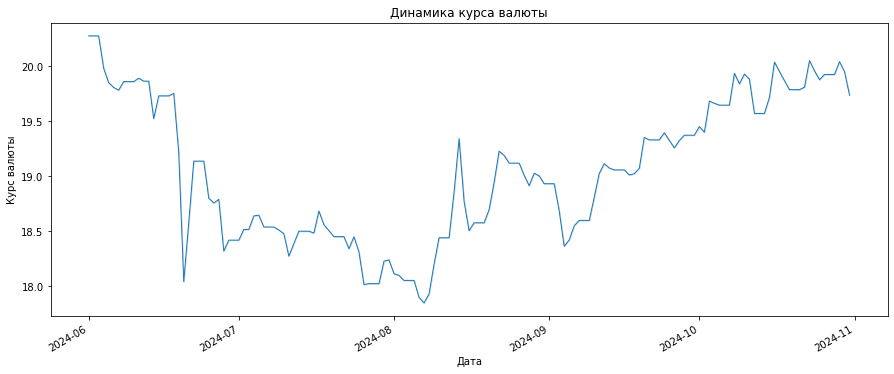

In [49]:
plt.figure(figsize=(15, 6))

sns.lineplot(data=df_merged, x='data', y='curs', linewidth=1)
plt.title('Динамика курса валюты')
plt.xlabel('Дата')
plt.ylabel('Курс валюты')
plt.gcf().autofmt_xdate()
plt.show()

In [50]:
df_merged['curs'].describe()

count    287146.000000
mean         19.188593
std           0.622319
min          17.848600
25%          18.599100
50%          19.325600
75%          19.788401
max          20.277300
Name: curs, dtype: float64

Курс за рассматриваемый период довольно волатилен с минимальным и максимальным значениями - 17,8 руб./100 тенге и 20,3 руб./100 тенге соответственно. Максимальное значение наблюдается в самом начале (июне), а минимальное в августе. Среднее значение составляет 19,2 руб./100 тенге.

#### Рассмотрим данные на наличие явных и неявных дубликатов:

In [51]:
# Явные дубликаты:
df_merged.duplicated().sum()

0

In [52]:
df_merged.duplicated(subset = ['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev', 'event_name', 
        'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name', 'venue_address']).sum()

30

В данных присутствуют 30 неявных дубликатов (по всем полям, кроме идентификатора заказа), поскольку идентификатор заказа для анализа не значим, удалим эти дубликаты, оставив первое вхождение данных:

In [53]:
df_dropped = df_merged.drop_duplicates(subset = ['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev', 'event_name', 
        'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name', 'venue_address'], keep = 'first')

In [54]:
duplicates = df_merged.shape[0] - df_dropped.shape[0]
print(f'Количество удаленных дубликатов составило {duplicates} шт.')

Количество удаленных дубликатов составило 30 шт.


#### Создадим новые столбцы:

Столбец `revenue_rub` со значениями выручки в рублях:

In [55]:
df_final = df_dropped.copy()

df_final['revenue_rub'] = np.where(
    df_final['currency_code'] == 'rub',
    df_final['revenue'],
    df_final['revenue'] / 100 * df_final['curs'])

In [56]:
df_final['revenue_rub'].describe()

count    287116.000000
mean        516.969727
std         508.780640
min           0.000000
25%         112.389999
50%         344.260010
75%         788.320007
max        3427.593018
Name: revenue_rub, dtype: float64

Столбец `one_ticket_revenue_rub` со значениями выручки на один билет в заказе:

In [57]:
df_final['one_ticket_revenue_rub'] = df_final['revenue_rub'] / df_final['tickets_count']

In [58]:
df_final['one_ticket_revenue_rub'].describe()

count    287116.000000
mean        190.724991
std         167.313599
min           0.000000
25%          46.263332
50%         146.158333
75%         305.495415
max        2438.270020
Name: one_ticket_revenue_rub, dtype: float64

Столбец `month` с месяцем заказа:

In [59]:
df_final['month'] = df_final['created_dt_msk'].dt.month

In [60]:
df_final['month'].unique()

array([ 8,  7, 10,  9,  6])

Столбец `season` со временем года заказа:

In [61]:
# Создадим функцию конвертации месяцев во времена года
def season(month):
    if month in [6, 7, 8]:
        return 'Лето'
    elif month in [9, 10]:
        return 'Осень'
    else:
        return 'Нет данных'

# Применим функцию к датасету
df_final['season'] = df_final['month'].apply(season)

In [62]:
df_final['season'].unique()

array(['Лето', 'Осень'], dtype=object)

In [63]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287116 entries, 0 to 290610
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287116 non-null  int32         
 1   user_id                 287116 non-null  object        
 2   created_dt_msk          287116 non-null  datetime64[ns]
 3   created_ts_msk          287116 non-null  datetime64[ns]
 4   event_id                287116 non-null  int32         
 5   cinema_circuit          287116 non-null  object        
 6   age_limit               287116 non-null  int8          
 7   currency_code           287116 non-null  object        
 8   device_type_canonical   287116 non-null  object        
 9   revenue                 287116 non-null  float32       
 10  service_name            287116 non-null  object        
 11  tickets_count           287116 non-null  int8          
 12  total                   287116

In [64]:
# Сократим размерность столбца month
df_final['month'] = pd.to_numeric(df_final['month'], downcast = 'integer')
df_final['month'].dtypes

dtype('int8')

In [65]:
# Посчитаем удаленные данные
outline_drop_sum = outline_rub_count + outline_kzt_count + under_zero_count + total_under_zero #удаленные выборсы
outline_drop_proc = round(outline_drop_sum / final_tickets_orders_df.shape[0]*100, 2) #процент удаленных выбросов
duplicates_proc =  round(duplicates / final_tickets_orders_df.shape[0]*100, 2) #процент удаленных дубликатов
all_dropped = outline_drop_sum + deleted_join + duplicates #все удаленные данные
all_dropped_proc = round(all_dropped / final_tickets_orders_df.shape[0]*100, 2) #процент всех удаленных данных

#### Промежуточный вывод:

По итогам предобработки данных поля были проверены на наличие пропусков, выбросов, дубликатов, кроме этого, данные были переведены в подходящий тип хранения. Также было создано 4 новых столбца.

**Типы данных:**
1. Поля с датой и временем `created_dt_msk` , `created_ts_msk`, `data` были приведены к типу `datetime`;
2. Поля `order_id`, `event_id`, `age_limit`, `tickets_count`, `revenue`, `total`, `days_since_prev`, `month`, `event_id`, `city_id`, `venue_id`, `nominal` и `curs` были снижены для соответствующей размерности;
3. В поле `days_since_prev` было создано значение-индикатор отсутствия данных `-1`.

**Пропуски:**

In [66]:
print(f'При объединении таблиц возникло {deleted_join} пропусков в информации о мероприятиях, это составило {deleted_join_proc}% от изначальных данных')

При объединении таблиц возникло 238 пропусков в информации о мероприятиях, это составило 0.08% от изначальных данных


**Выбросы:**

In [67]:
print(f'В поле revenue были замечены аномально большие значения, а также значения меньше нуля, в поле total - значения меньше нуля. В связи с этим было удалено {outline_drop_sum} данных, это составило {outline_drop_proc}% от изначальных данных')

В поле revenue были замечены аномально большие значения, а также значения меньше нуля, в поле total - значения меньше нуля. В связи с этим было удалено 3465 данных, это составило 1.19% от изначальных данных


**Дубликаты:**

In [68]:
print(f'Было обнаружено и удалено {duplicates} неявных дубликатов по всем полям, кроме order_id, это составило {duplicates_proc}% от изначальных данных')

Было обнаружено и удалено 30 неявных дубликатов по всем полям, кроме order_id, это составило 0.01% от изначальных данных


In [69]:
print(f'Таким образом, по итогам предобработки было удалено {all_dropped} данных, что составило {all_dropped_proc}% от изначальных данных')

Таким образом, по итогам предобработки было удалено 3733 данных, что составило 1.28% от изначальных данных


**Новые столбцы:**
- `revenue_rub` - с выручкой в рублях для всех наблюдений;
- `one_ticket_revenue_rub` - с выручкой в рублях на один билет в заказе;
- `month` - с месяцем заказа;
- `season` - с временем года заказа.

### Шаг 3. Исследовательский анализ данных

####  Анализ распределения заказов по сегментам и их сезонные изменения

Рассмотрим динамику изменения общего количества заказов:

In [70]:
df_month_orders = df_final.groupby('month')['order_id'].count().reset_index()

<Figure size 720x432 with 0 Axes>

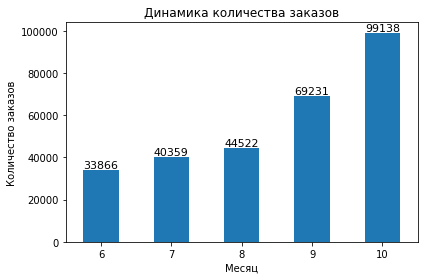

In [71]:
plt.figure(figsize=(10, 6))
ax = df_month_orders.plot(kind='bar', x='month', y='order_id', legend=False, rot=0)

# Добавляем подписи на каждый столбец
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Форматирование без десятичных знаков
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Позиция
                ha='center', va='center',  # Выравнивание по центру
                xytext=(0, 5),            # Смещение по вертикали
                textcoords='offset points', # Система координат
                fontsize=11)               # Размер шрифта

plt.title('Динамика количества заказов')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.tight_layout()
plt.show()

Заметен явный тренд на увеличение количества заказов с течением времени, в осенние месяцы темп роста количества заказов увеличивается.

Рассмотрим более детально распределение по **типу мероприятия**:

In [72]:
df_type_orders = df_final.groupby(['month', 'event_type_main'])['order_id'].count().reset_index()

df_type_orders['month_total'] = df_type_orders.groupby('month')['order_id'].transform('sum') # общая сумма по месяцам

# доля каждого события в разрезе месяца
df_type_orders['type_share'] = round(df_type_orders['order_id'] / df_type_orders['month_total']*100, 2) 

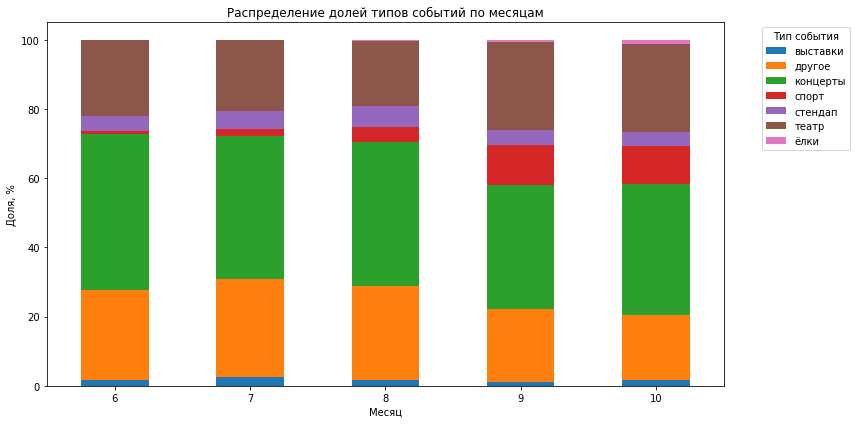

In [73]:
pivot_type = df_type_orders.pivot(index='month', columns='event_type_main', values='type_share').fillna(0)

plt.figure(figsize=(12, 6))
pivot_type.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Распределение долей типов событий по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Доля, %')
plt.legend(title='Тип события', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

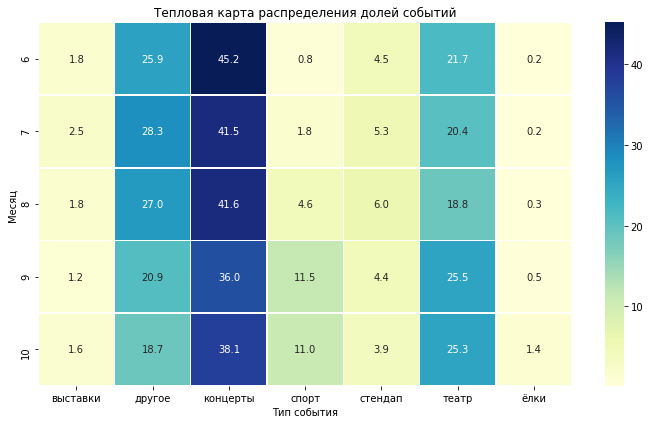

In [74]:
plt.figure(figsize=(10, 6))
heatmap_type = df_type_orders.pivot('month', 'event_type_main', 'type_share')
sns.heatmap(heatmap_type, annot=True, fmt='.1f', cmap='YlGnBu', linewidths=.5)
plt.title('Тепловая карта распределения долей событий')
plt.xlabel('Тип события')
plt.ylabel('Месяц')
plt.tight_layout()
plt.show()

Основу данных занимают такие типы мероприятий как `концерты`, `театр` и `другое`. Осенью, по сравнению с летом, доли мероприятий типа `концерты` и `другое` снизились, а доля типа `театр` наоборот возрасла, кроме этого, к осени значительно выросли доли типа `спорт`, котрые до этого не занимали большую часть данных.

Рассмотрим более детально распределение по **девайсам**:

In [75]:
df_device_orders = df_final.groupby(['month', 'device_type_canonical'])['order_id'].count().reset_index()

df_device_orders['month_total'] = df_device_orders.groupby('month')['order_id'].transform('sum') # общая сумма по месяцам

# доля каждого девайса в разрезе месяца
df_device_orders['device_share'] = round(df_device_orders['order_id'] / df_device_orders['month_total']*100, 2)

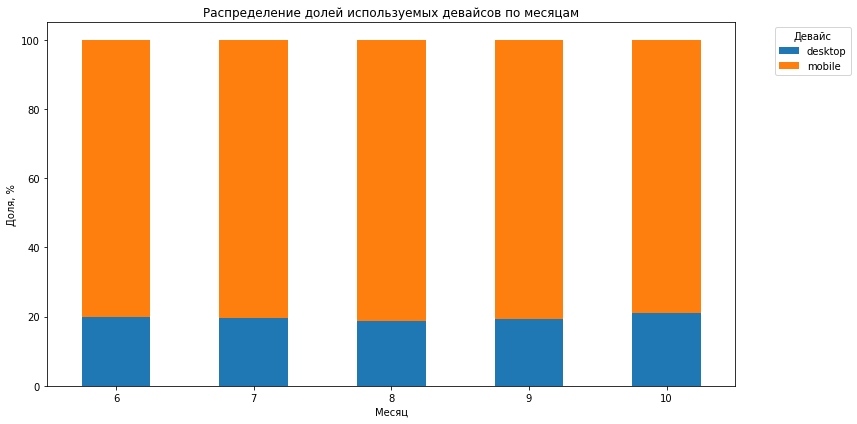

In [76]:
pivot_device = df_device_orders.pivot(index='month', columns='device_type_canonical', values='device_share').fillna(0)

plt.figure(figsize=(12, 6))
pivot_device.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Распределение долей используемых девайсов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Доля, %')
plt.legend(title='Девайс', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Распределение используемых девайсов в разрезе периодов стабильно представлено соотношением 80/20 % для компьютеров и мобильных устройств соответственно.

Рассмотрим более детально распределение по **возрастному ограничению мероприятий**:

In [77]:
df_age_orders = df_final.groupby(['month', 'age_limit'])['order_id'].count().reset_index()

df_age_orders['month_total'] = df_age_orders.groupby('month')['order_id'].transform('sum') # общая сумма по месяцам

# доля каждого возрастного ограничения в разрезе месяца
df_age_orders['age_share'] = round(df_age_orders['order_id'] / df_age_orders['month_total']*100, 2)

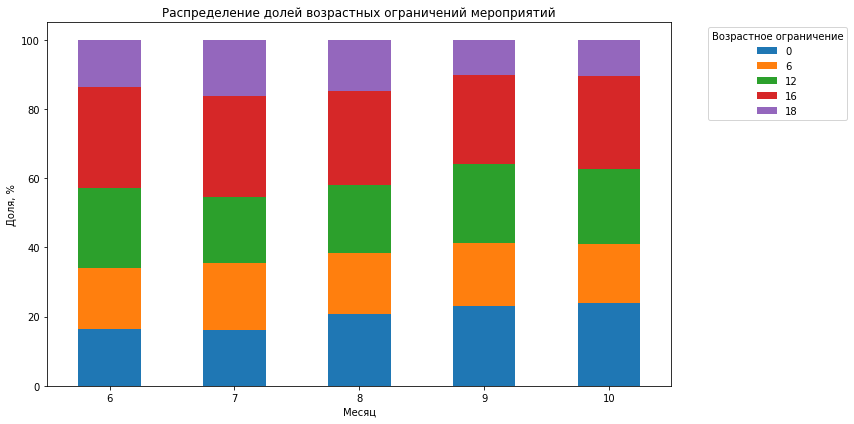

In [78]:
pivot_age = df_age_orders.pivot(index='month', columns='age_limit', values='age_share').fillna(0)

plt.figure(figsize=(12, 6))
pivot_age.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Распределение долей возрастных ограничений мероприятий')
plt.xlabel('Месяц')
plt.ylabel('Доля, %')
plt.legend(title='Возрастное ограничение', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

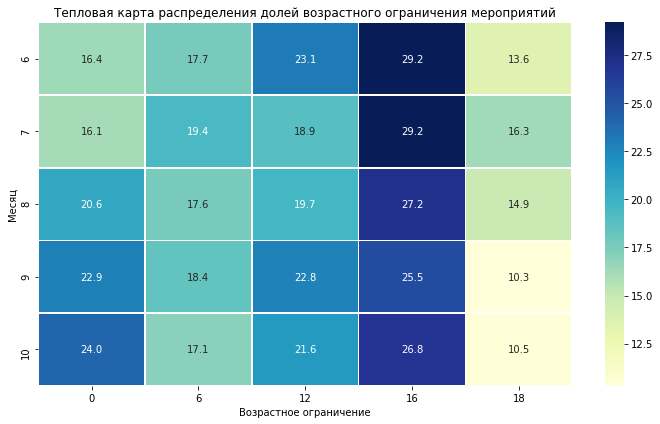

In [79]:
plt.figure(figsize=(10, 6))
heatmap_age = df_age_orders.pivot('month', 'age_limit', 'age_share')
sns.heatmap(heatmap_age, annot=True, fmt='.1f', cmap='YlGnBu', linewidths=.5)
plt.title('Тепловая карта распределения долей возрастного ограничения мероприятий')
plt.xlabel('Возрастное ограничение')
plt.ylabel('Месяц')
plt.tight_layout()
plt.show()

Основу данных занимают мероприятия с возрастными ограничениями `16+`, `0+`, `12+` и `6+`. Ближе к осени мероприятия `0+`стали более популярны, а мероприятия `18+` наоборот стали менее популярны. Распределение мероприятий с другими возрастыми ограничениями оставалось довольно стабильным на протяжении всего периода.

Рассмотрим изменение **выручки с продажи одного билета в разрезе сезонов и типа мероприятий**:

In [80]:
df_type_revenue_ticket = df_final.groupby(['season', 'event_type_main'])['one_ticket_revenue_rub'].mean().reset_index()

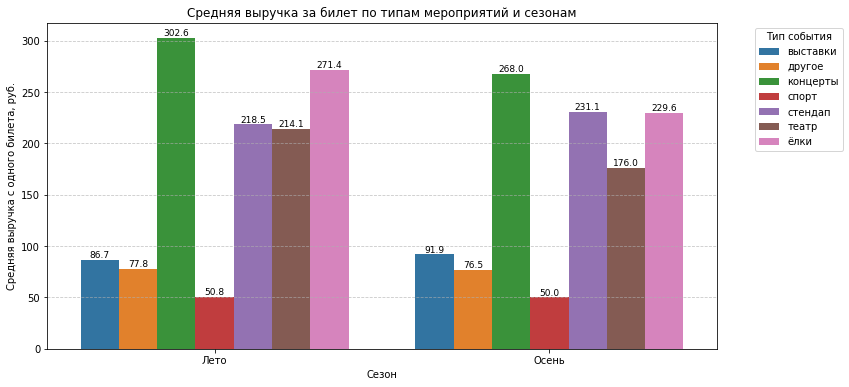

In [81]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_type_revenue_ticket, 
            x='season', 
            y='one_ticket_revenue_rub', 
            hue='event_type_main' 
            )

plt.title('Средняя выручка за билет по типам мероприятий и сезонам')
plt.xlabel('Сезон')
plt.ylabel('Средняя выручка с одного билета, руб.')
plt.legend(title='Тип события', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points',
                fontsize=9)

In [82]:
# общее среднее по сезонам
df_final.groupby('season')['one_ticket_revenue_rub'].mean()

season
Лето     208.479553
Осень    178.203049
Name: one_ticket_revenue_rub, dtype: float32

На основе графика можно сделать следующие выводы изменения метрики в течение лето и осени:
1. Значительно снизилась средняя выручка за один билет с мероприятий типа `концерты`, `театр` и `ёлки`.
2. Возрасли лишь показатели для мероприятий типа `выставки` и `стендап`.
3. Мероприятия типа `спорт` и `другое` в разрезе сезонов не показати сильное изменение средней выручки с билета.

Рассмотрим также распределение заказов по категориям в разрезе сезонов:

**Количество заказов по типу мероприятия:**

In [83]:
df_type_order_count = df_final.groupby(['season', 'event_type_main'])['order_id'].count().reset_index()

df_type_order_count['season_total'] = df_type_order_count.groupby('season')['order_id'].transform('sum') # общая сумма сезона
# доля каждого типа в разрезе сезона
df_type_order_count['type_share'] = round(df_type_order_count['order_id'] / df_type_order_count['season_total']*100, 2)

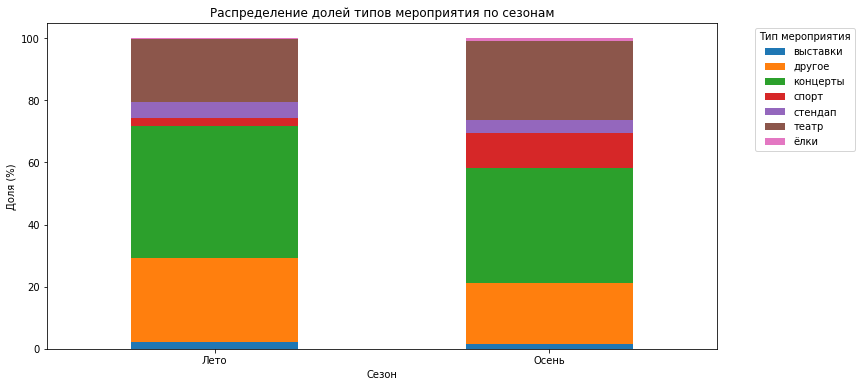

In [84]:
pivot_type_share = df_type_order_count.pivot(index='season', columns='event_type_main', values='type_share').fillna(0)

plt.figure(figsize=(12, 6))
pivot_type_share.plot(kind='bar', stacked=True, ax=plt.gca())

plt.title('Распределение долей типов мероприятия по сезонам')
plt.xlabel('Сезон')
plt.ylabel('Доля (%)')
plt.legend(title='Тип мероприятия', bbox_to_anchor=(1.05, 1), loc='upper left')  # Положение легенды
plt.xticks(rotation=0)

plt.show()

In [85]:
pivot_type_share

event_type_main,выставки,другое,концерты,спорт,стендап,театр,ёлки
season,,,,,,,
Лето,2.03,27.12,42.58,2.53,5.34,20.16,0.23
Осень,1.43,19.64,37.23,11.20,4.11,25.38,1.00


Ключевые изменения показателей к осени коснулись таких типов как: 
- `другое` - падение на 7.48 п.п.
- `спорт` - увеличение на 8.67 п.п.
- `коцерты` - падение на 5.35 п.п.
- `театр` - увеличение на 5.22 п.п.

**Количество заказов по типу устройств:**

In [86]:
df_device_order_count = df_final.groupby(['season', 'device_type_canonical'])['order_id'].count().reset_index()

df_device_order_count['season_total'] = df_device_order_count.groupby('season')['order_id'].transform('sum') # общая сумма сезона
# доля каждого девайса в разрезе сезона
df_device_order_count['device_share'] = round(df_device_order_count['order_id'] / df_device_order_count['season_total']*100, 2)

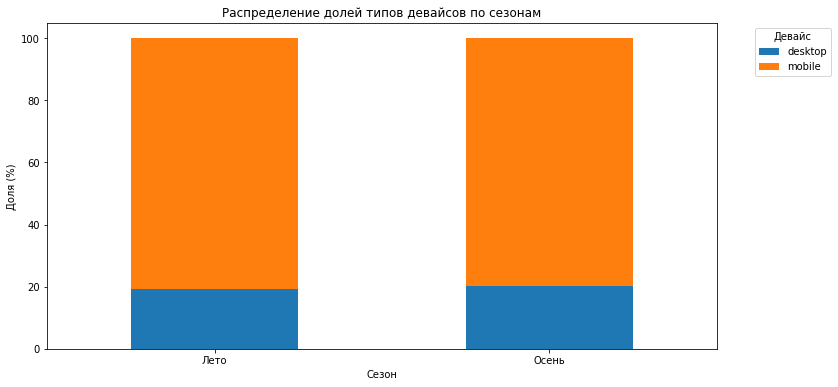

In [87]:
pivot_device_share = df_device_order_count.pivot(index='season', columns='device_type_canonical', values='device_share').fillna(0)

plt.figure(figsize=(12, 6))
pivot_device_share.plot(kind='bar', stacked=True, ax=plt.gca())

plt.title('Распределение долей типов девайсов по сезонам')
plt.xlabel('Сезон')
plt.ylabel('Доля (%)')
plt.legend(title='Девайс', bbox_to_anchor=(1.05, 1), loc='upper left')  # Положение легенды
plt.xticks(rotation=0)

plt.show()

In [88]:
pivot_device_share

device_type_canonical,desktop,mobile
season,,
Лето,19.34,80.66
Осень,20.36,79.64


Распределение по сезонам осталось примерно равным 80/20 для `мобильных устройств` и `компьютеров` соответственно. Осенью использование `компьютеров` выросло на 1 п.п.

**Количество заказов по возрастным ограничениям мероприятия:**

In [89]:
df_age_order_count = df_final.groupby(['season', 'age_limit'])['order_id'].count().reset_index()

df_age_order_count['season_total'] = df_age_order_count.groupby('season')['order_id'].transform('sum') # общая сумма сезона
# доля каждого возрастного ограничения в разрезе сезона
df_age_order_count['age_share'] = round(df_age_order_count['order_id'] / df_age_order_count['season_total']*100, 2)

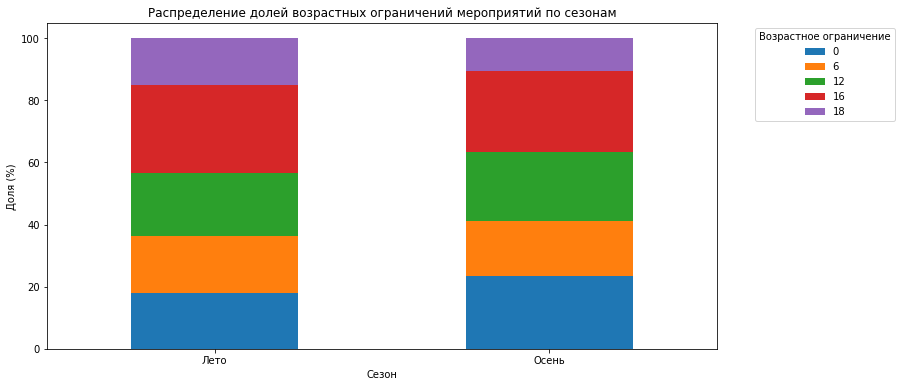

In [90]:
pivot_age_share = df_age_order_count.pivot(index='season', columns='age_limit', values='age_share').fillna(0)

plt.figure(figsize=(12, 6))
pivot_age_share.plot(kind='bar', stacked=True, ax=plt.gca())

plt.title('Распределение долей возрастных ограничений мероприятий по сезонам')
plt.xlabel('Сезон')
plt.ylabel('Доля (%)')
plt.legend(title='Возрастное ограничение', bbox_to_anchor=(1.05, 1), loc='upper left')  # Положение легенды
plt.xticks(rotation=0)

plt.show()

In [91]:
pivot_age_share

age_limit,0,6,12,16,18
season,,,,,
Лето,17.92,18.24,20.4,28.43,15.01
Осень,23.58,17.63,22.1,26.26,10.43


Ключевые изменения показателей к осени коснулись таких возрастных ораничений как: 
- `0+` - увеличение на 5.66 п.п.
- `18+` - падение на 4.58 п.п.

####  Промежуточный вывод:

Рассматривая динамику показателей по месяцам и сезонам можно отметить тренд на увеличение количество заказов, темп которго нарастает с наступлением осени, однако средняя выручка с одного билета осенью по сравнению с летом упала на 30 рублей.

- Основу данных в каждом месяце занимают такие типы мероприятий как `концерты`, `театр` и `другое`. Осенью, по сравнению с летом, доли мероприятий типа `концерты` и `другое` снизились, а доля типа `театр` наоборот возрасла, кроме этого, к осени значительно выросли доли типа `спорт`, котрые до этого не занимали большую часть данных.
- Распредленеие по девайсам стабильно представлено соотношением 80/20 для `телефонов` и `компьютеров` соответственно.
- Мероприятия `0+` стали более популяны ближе к осени, а мероприятия `18+` наоборот стали менее популярны. Основу данных стабильно занимают мероприятия `16+`.
- В разрезе типов мероприятий к осени значительно снизилась средняя выручка за один билет с мероприятий типа `концерты`, `театр` и `ёлки`, немного возрасла средняя выручка с типов `выставки` и `стендап`.
- Также рассматривая распределение по сезонам можно выделить следующие ключевые изменения к осени:
    - Доля мероприятий типа `концерты` упала, но все равно осталось самой большой, доля типа `театр` выросла и оказалась на втором месте, сместив тип `другое`, доля которго также значительно упала и переместилась на третье место осенью.
    - Стали популярнее мероприятия с возрастным ограничением `0+`, доля которых возрасла, а доля мероприятий `18+` наоборот упала.

####  Осенняя активность пользователей

In [92]:
# Отбираем данные за осень
df_autumn = df_final.loc[df_final['season'] == 'Осень']

In [93]:
pivot_days = (df_autumn.pivot_table(index='created_dt_msk', values=['order_id', 'user_id', 'one_ticket_revenue_rub'], aggfunc= {
    'order_id' : "count", 'user_id' : "nunique", 'one_ticket_revenue_rub': "mean"})
              .rename(columns={'order_id': 'Количество заказов',
                               'user_id': 'DAU',
                               'one_ticket_revenue_rub': 'Средняя выручка с билета'})
                                                                                     .rename_axis('День'))

pivot_days['Среднее количество заказов на пользователя'] = round(pivot_days['Количество заказов'] / 
                                                                 pivot_days['DAU'],1) # среднее количество заказов на человека

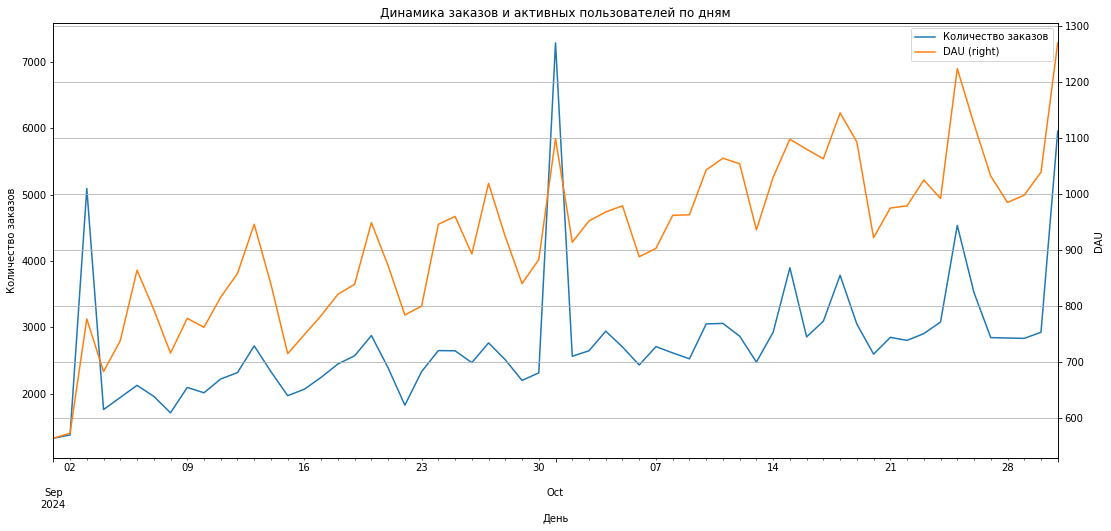

In [94]:
ax = pivot_days[['Количество заказов', 'DAU']].plot(
    kind='line',
    secondary_y=['DAU'],  # DAU на правой оси графика
    title='Динамика заказов и активных пользователей по дням',
    figsize=(18, 8))

# Установка подписей для осей Y
ax.set_ylabel('Количество заказов')
ax.right_ax.set_ylabel('DAU')

plt.grid(True)
plt.show()

In [97]:
pivot_days.sort_values(by = 'Количество заказов', ascending = False).head(3)

,Средняя выручка с билета,Количество заказов,DAU,Среднее количество заказов на пользователя
День,,,,
2024-10-01,95.289383,7288,1099,6.6
2024-10-31,150.657166,5956,1270,4.7
2024-09-03,80.429375,5092,777,6.6


Можно отметить сильную волатильность графика с явным влиянием дней недели на показатели, также присутсвуют пики количества заказов в начале обоих месяцев осени. Две даты приходятся на `вторник` и одна на `четверг`. Присутствует тренд на постепенное увеличение количества заказов и количества пользователей.

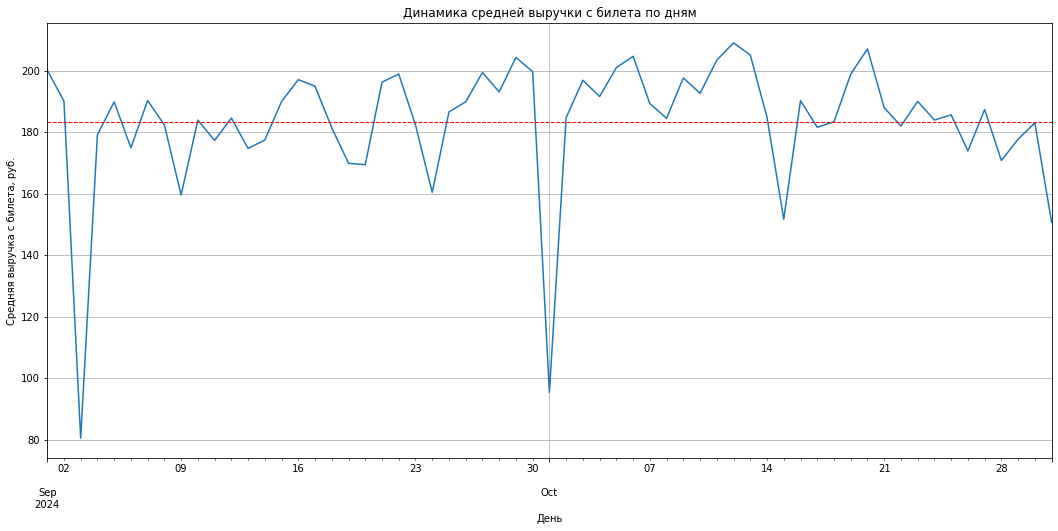

183.3084

In [98]:
mean_rev = pivot_days['Средняя выручка с билета'].mean()

pivot_days['Средняя выручка с билета'].plot(
    kind='line',
    title='Динамика средней выручки с билета по дням',
    figsize=(18, 8))

plt.axhline(mean_rev,
color='red',
linestyle='--',
linewidth=1)

plt.grid(True)
plt.ylabel('Средняя выручка с билета, руб.')
plt.show()
display(mean_rev)

График средней выручки с билета также волатилен, со средним значением в 183 рубля, в начале обоих месяцев осени присутствуют отрицательные пики показателя.

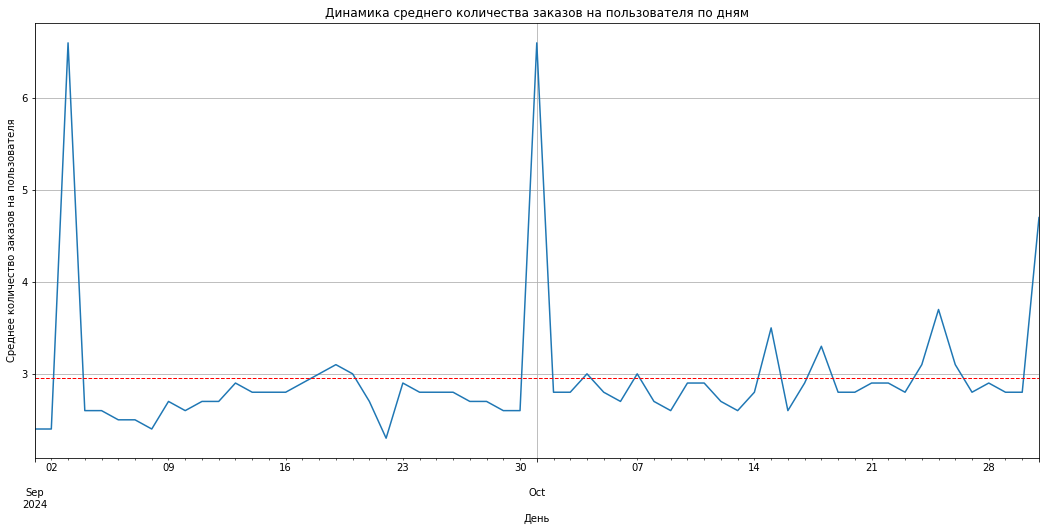

In [99]:
mean_ord = pivot_days['Среднее количество заказов на пользователя'].mean()

pivot_days['Среднее количество заказов на пользователя'].plot(
    kind='line',
    title='Динамика cреднего количества заказов на пользователя по дням',
    figsize=(18, 8))

plt.axhline(mean_ord,
color='red',
linestyle='--',
linewidth=1)

plt.grid(True)
plt.ylabel('Среднее количество заказов на пользователя')
plt.show()

Динамика графика напоминает динамику общего количества заказов со схожей волатильностью и пиками в начале обоих месяцев осени.

**Рассмотрим динамику по дням недели:**

In [100]:
df_weeks = df_autumn[['order_id', 'user_id', 'created_dt_msk', 'one_ticket_revenue_rub', 'revenue_rub', 'tickets_count']].copy()
df_weeks['weekday'] = df_weeks['created_dt_msk'].dt.day_name()

# Перевод дней недели на Русский язык
days_translation = {
    'Monday': 'Понедельник',
    'Tuesday': 'Вторник',
    'Wednesday': 'Среда',
    'Thursday': 'Четверг',
    'Friday': 'Пятница',
    'Saturday': 'Суббота',
    'Sunday': 'Воскресенье'}

df_weeks['День недели'] = df_weeks['weekday'].map(days_translation)

In [101]:
weeks_grouped = df_weeks.groupby('День недели').agg({'order_id': 'count', 'user_id': 'nunique', 
                                                     'one_ticket_revenue_rub': 'mean', 'revenue_rub': 'sum',
                                                    'tickets_count': 'sum'}).reset_index()

# Порядок дней недели
ordered_days = ['Понедельник', 
                'Вторник', 
                'Среда', 
                'Четверг', 
                'Пятница', 
                'Суббота', 
                'Воскресенье']

# Устанавливаем порядок для столбца weekday_ru
weeks_grouped['День недели'] = pd.Categorical(weeks_grouped['День недели'], categories=ordered_days, ordered=True)

# Упорядочиваем по столбцу weekday_ru
weeks_grouped = weeks_grouped.sort_values('День недели')

# Создаем столбец с средним количеством заказов на пользователя
weeks_grouped['Среднее количество заказов на пользователя'] = round(weeks_grouped['order_id'] / weeks_grouped['user_id'], 1)

# Переименовываем столбцы
weeks_grouped = weeks_grouped.rename(columns={'order_id': 'Количество заказов',
                                              'user_id': 'DAU',
                                              'one_ticket_revenue_rub': 'Средняя выручка с билета',
                                              'revenue_rub': 'Общая выручка',
                                              'tickets_count': 'Количество билетов'})

weeks_grouped

,День недели,Количество заказов,DAU,Средняя выручка с билета,Общая выручка,Количество билетов,Среднее количество заказов на пользователя
2,Понедельник,21493,4442,184.280548,10749470.0,58535.0,4.8
1,Вторник,31429,4791,140.698929,12152227.0,89488.0,6.6
4,Среда,22840,4810,185.962067,11496708.0,61553.0,4.7
6,Четверг,27115,4964,178.242157,13006568.0,72418.0,5.5
3,Пятница,24800,4869,185.683716,12590706.0,68184.0,5.1
5,Суббота,21320,4567,192.223938,11272078.0,59244.0,4.7
0,Воскресенье,19372,4392,198.096222,10485456.0,53107.0,4.4


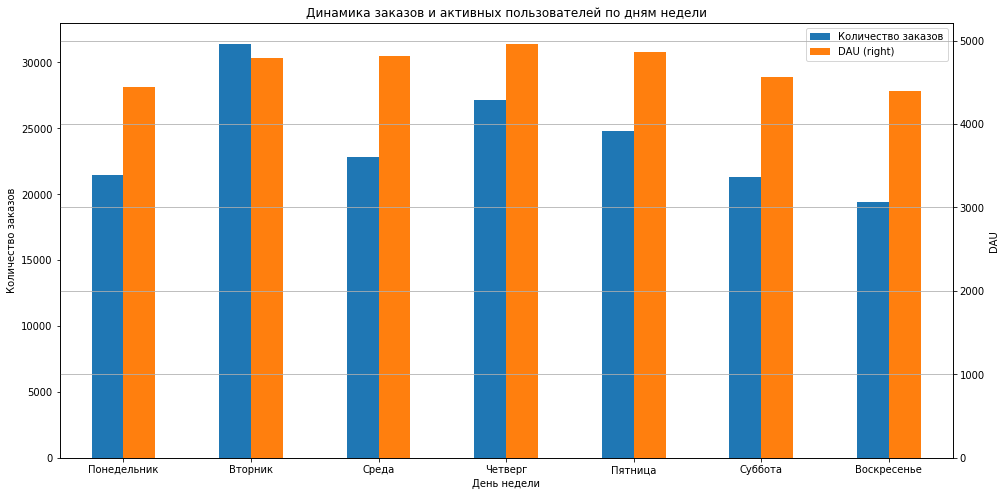

In [102]:
ax = weeks_grouped[['День недели', 'Количество заказов', 'DAU']].plot(
    x='День недели',
    kind='bar',
    secondary_y=['DAU'],  # DAU на правой оси графика
    title='Динамика заказов и активных пользователей по дням недели',
    rot=0,
    figsize=(16, 8)
)

# Установка подписей для осей Y
ax.set_ylabel('Количество заказов')
ax.right_ax.set_ylabel('DAU')

plt.grid(True)
plt.show()

Пик количества заказов приходится на `Вторник`, однако резко падает к `Среде`, снова увеличивается к `Четвергу` и после этого плавно снижается к `Воскресенью`. 

Самое маленькое число заказов и активных пользователей приходится на `Понедельник` и `Воскресенье`. В остальные дни недели число активных пользователей принимает макисмальное значение в `Четверг` и также плавно снижается к `Воскресенью`.

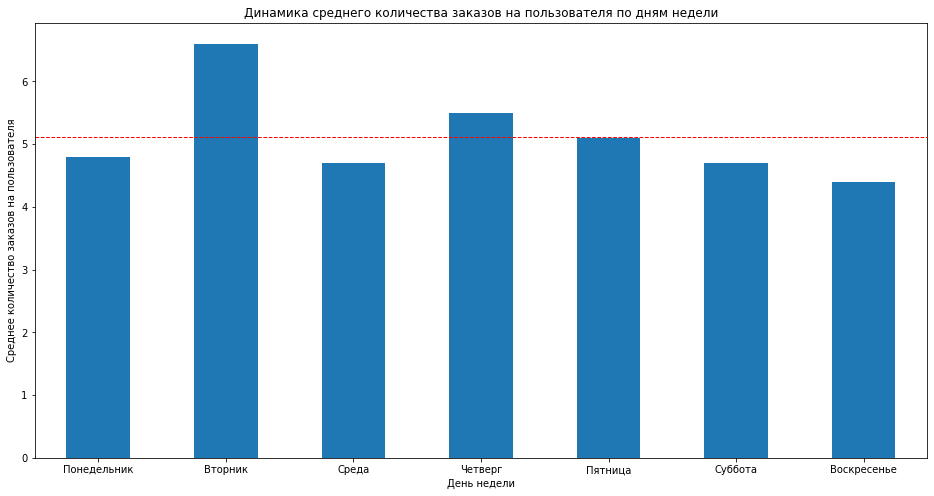

In [103]:
mean_rev = weeks_grouped['Среднее количество заказов на пользователя'].mean()

weeks_grouped[['День недели','Среднее количество заказов на пользователя']].plot(
    x = 'День недели',
    kind='bar',
    rot = 0,
    legend = False,
    title='Динамика среднего количества заказов на пользователя по дням недели',
    figsize=(16, 8))

plt.axhline(mean_rev,
color='red',
linestyle='--',
linewidth=1)

plt.ylabel('Среднее количество заказов на пользователя')
plt.show()

Динамика графика совпадает с динамикой общего количества заказов по дням недели.

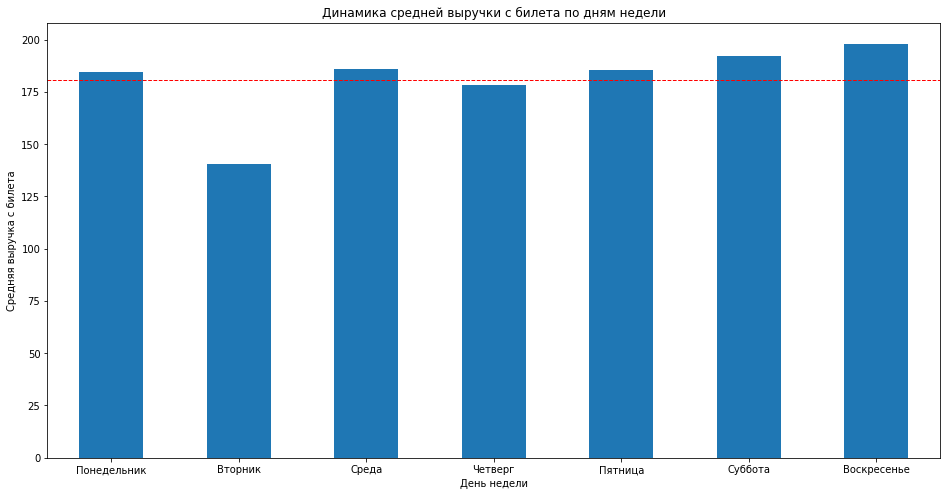

In [104]:
mean_rev = weeks_grouped['Средняя выручка с билета'].mean()

weeks_grouped[['День недели','Средняя выручка с билета']].plot(
    x = 'День недели',
    kind='bar',
    rot = 0,
    legend = False,
    title='Динамика средней выручки с билета по дням недели',
    figsize=(16, 8))

plt.axhline(mean_rev,
color='red',
linestyle='--',
linewidth=1)

plt.ylabel('Средняя выручка с билета')
plt.show()

Средняя выручка имеет противоположную тенденцию относительно количества заказов. Минимальное значение достигается во `вторник`, где количество заказов самое большое, а по мере снижения количества заказов к `воскресенью` средняя выручка увеличивается и достигает своего пика в `воскресенье`.

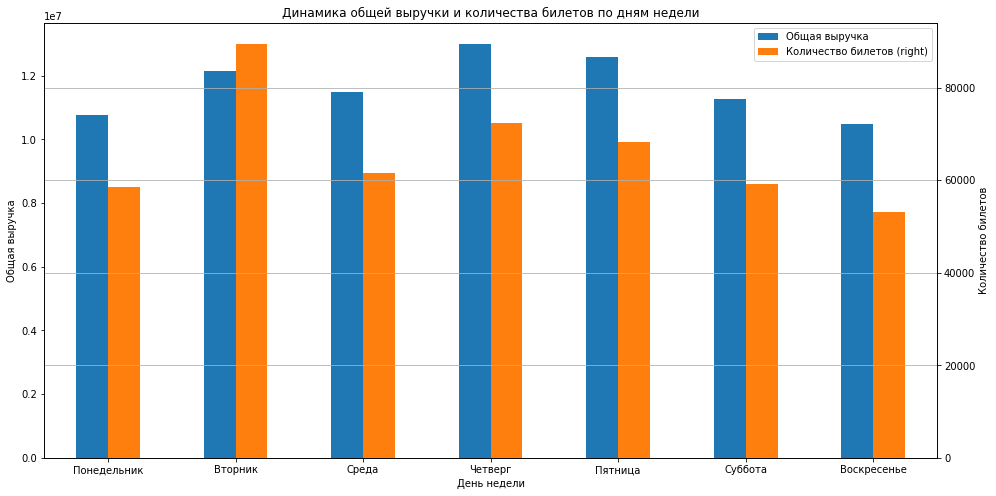

In [105]:
ax = weeks_grouped[['День недели','Общая выручка', 'Количество билетов']].plot(
    x = 'День недели',
    kind='bar',
    secondary_y=['Количество билетов'],  # DAU на правой оси графика
    title='Динамика общей выручки и количества билетов по дням недели',
    rot = 0,
    figsize=(16, 8))

# Установка подписей для осей Y
ax.set_ylabel('Общая выручка')
ax.right_ax.set_ylabel('Количество билетов')

plt.grid(True)
plt.show()

Такое резкое снижение средней выручки с билета по вторникам можно объяснить тем, что пользователи покупают наибольшее количество билетов во вторник, в то время как общая выручка в этот день недели не максимальная.

####  Промежуточный вывод:

За исследуемые два месяца осени (`Сентябрь` и `Октябрь`) заметен общий тренд на постепенное увеличение количества заказов и пользователей с сильной волатильностью по дням недели. Пиковые значения количества заказов приходятся на начало месяцев, в частности два раза на `Вторник` и один раз на `Четверг`. 

- Среднее количество заказов на пользователя совпадает с динамикой общего количества заказов, однако средняя выручка с билета имеет обратную тенденцию, принимая минимальные значения в периоды, когда количество заказов наибольшее.

- Рассматривая динамику по дням недели, стоит отметить пиковое значение количества заказов во `Вторник` и резкое снижение к `Среде`. На втором месте по количеству заказов находится `Четверг`, после которого показатель постепенно снижается к `Воскресенью`. Количество пользователей в свою очередь принимает максимальное значение в `Четверг` и также постепенно снижается к `Воскресенью`.

- Самыми непопулярными днями в приложении являются `Воскресенье` и `Понедельник`.

- Влияние резкого снижения средней выручки с одного билета во `Вторник` можно объяснить тем, что количество купленных билетов в этот день максимальное, а общая выручка не максимальна.

####  Популярные события и партнеры

**Регионы и мероприятия:**

In [106]:
df_regions = df_final.groupby('region_name').agg({
    'order_id': 'count', 'event_id': 'nunique'}).reset_index().sort_values(by = 'order_id', ascending = False)

df_regions['Доля заказов'] = round(df_regions['order_id'] / df_final['order_id'].count()*100,2)
df_regions['Доля уникальных мероприятий'] = round(df_regions['event_id'] / df_final['event_id'].nunique()*100,2)

df_regions = df_regions.rename(columns={'order_id': 'Количество заказов',
                                        'event_id': 'Количество мероприятий',
                                        'region_name': 'Регион'})
df_regions[['Регион', 'Количество заказов', 'Доля заказов']].head(10)

,Регион,Количество заказов,Доля заказов
23,Каменевский регион,89663,31.23
60,Североярская область,43725,15.23
77,Широковская область,16099,5.61
42,Медовская область,13891,4.84
45,Озернинский край,10348,3.60
57,Светополянский округ,7487,2.61
41,Малиновоярский округ,6314,2.20
52,Речиновская область,6266,2.18
64,Солнечноземская область,6238,2.17
78,Яблоневская область,6120,2.13


Основным регионом по количеству заказов (**89 663 заказа**) является `Каменевский регион`, количество заказов в нем составляет **31.2%** от общего количества данных. На втором месте находится `Североярская область` с **43 725 заказами**, что составляет **15.2%** от общего количества данных.

Оставшиеся места в ТОП-10 занимают регионы с долями **от 2.1% до 5.6%**. В общем, ТОП-10 регионов составляют **72%** от общего количества заказов.

После ТОП-10 находятся регионы с долями **меньше 2%**, это **меньше 6 000 заказов**

In [107]:
df_regions[['Регион', 'Количество заказов', 'Доля заказов']].tail(1)

,Регион,Количество заказов,Доля заказов
68,Теплоозёрский округ,7,0.0


На последнем месте находится `Теплоозерский округ` с **7 заказами**.

In [108]:
df_regions[['Регион', 'Количество мероприятий', 'Доля уникальных мероприятий']].sort_values(
    by = 'Количество мероприятий', ascending = False).head(7)

,Регион,Количество мероприятий,Доля уникальных мероприятий
23,Каменевский регион,5934,26.62
60,Североярская область,3798,17.04
77,Широковская область,1225,5.50
57,Светополянский округ,1068,4.79
52,Речиновская область,701,3.14
74,Травяная область,683,3.06
11,Горицветская область,551,2.47


In [109]:
df_regions[['Регион', 'Количество мероприятий', 'Доля уникальных мероприятий']].sort_values(
    by = 'Количество мероприятий', ascending = False).tail()

,Регион,Количество мероприятий,Доля уникальных мероприятий
56,Светолесский край,2,0.01
33,Лесноярский край,2,0.01
5,Верхозёрский край,2,0.01
66,Сосноводолинская область,2,0.01
68,Теплоозёрский округ,2,0.01


Если рассматривать регионы по количество проведенных уникальных мероприятий, то две первые позиции снова занимают `Каменевский регион` и `Североярская область`, в них провелось **26.6%** и **17%** от общего числа уникальных мероприятий соответсвенно, что в абсолютных значениях составило  **5 934** и **3 798** мероприятий.

После ТОП-6 находятся регионы с долей **меньше 3%** или **меньше 600 мероприятий**. Последнее место заняли сразу 5 регионов лишь с 2 уникальными мероприятиями.

**Партнеры и мероприятия:**

In [110]:
df_service_name = df_final.groupby('service_name').agg({
    'order_id': 'count', 
    'event_id': 'nunique', 
    'revenue_rub': 'sum'}).reset_index().sort_values(by = 'order_id', ascending = False)

df_service_name['Доля заказов'] = round(df_service_name['order_id'] / df_final['order_id'].count()*100,2)
df_service_name['Доля уникальных мероприятий'] = round(df_service_name['event_id'] / df_final['event_id'].nunique()*100,2)
df_service_name['Доля выручки'] = round(df_service_name['revenue_rub'] / df_final['revenue_rub'].sum()*100,2)

df_service_name = df_service_name.rename(columns={'order_id': 'Количество заказов',
                                    'event_id': 'Количество мероприятий',
                                    'revenue_rub': 'Выручка',
                                    'service_name': 'Партнер'})
df_service_name[['Партнер', 'Количество заказов', 'Доля заказов']].head(10)

,Партнер,Количество заказов,Доля заказов
3,Билеты без проблем,62605,21.80
21,Лови билет!,40764,14.20
5,Билеты в руки,40188,14.00
24,Мой билет,34244,11.93
25,Облачко,26402,9.20
22,Лучшие билеты,17715,6.17
8,Весь в билетах,16410,5.72
26,Прачечная,10222,3.56
19,Край билетов,6109,2.13
30,Тебе билет!,5176,1.80


In [111]:
df_service_name[['Партнер', 'Количество заказов', 'Доля заказов']].tail(1)

,Партнер,Количество заказов,Доля заказов
4,Билеты в интернете,4,0.0


Распределение по партнерам более равномерное, нежели чем по регионам. По количеству заказов на первом месте находится `Билеты без проблем` с **62 605 заказами** - **21.8%** от общего количества. Второе и третье место занимают `Лови билет!` и `Билеты в руки` с долями **14.2%** и **14%** соответственно (в среднем 40 476 зкакзов). На 4 месте `Мой билет` - **12%**, на пятом `Облачко` - 9.2%, далее доли не превышают **6.2%**, а после ТОП-9 партнеров, количество заказов не превышает **6 000 заказов (2%)**. Последнее место занимает `Билеты в интернете` c **4 заказами**.

В общем, ТОП-9 партнеров занимают **88.7%** от общего количества заказов.

In [112]:
df_service_name[['Партнер', 'Количество мероприятий',
              'Доля уникальных мероприятий']].sort_values(by = 'Количество мероприятий', ascending = False).head(10)

,Партнер,Количество мероприятий,Доля уникальных мероприятий
21,Лови билет!,4859,21.80
3,Билеты без проблем,4209,18.88
5,Билеты в руки,3517,15.78
25,Облачко,2335,10.47
22,Лучшие билеты,1755,7.87
24,Мой билет,1300,5.83
30,Тебе билет!,1061,4.76
26,Прачечная,1026,4.60
8,Весь в билетах,855,3.84
35,Яблоко,714,3.20


По окличеству мероприятий на 1 место вышел `Лови билет!` с долей **21.8%** (**4 859 мероприятий**). На втором - `Билеты без проблем` - **18.9%**, ТОП-5 замыкает `Лучшие билеты` с **7.9%** (**1 755 мероприятий**). После ТОП-5 количество уникальных мероприятий у площадок не превышает **1 300**.

In [113]:
df_service_name[['Партнер', 'Выручка',
              'Доля выручки']].sort_values(by = 'Выручка', ascending = False).head(10)

,Партнер,Выручка,Доля выручки
3,Билеты без проблем,24255760.0,16.34
24,Мой билет,21357110.0,14.39
25,Облачко,18588614.0,12.52
21,Лови билет!,16670375.0,11.23
8,Весь в билетах,16494669.0,11.11
5,Билеты в руки,13194799.0,8.89
19,Край билетов,6405689.0,4.32
26,Прачечная,4746810.5,3.20
13,Дом культуры,4358656.0,2.94
35,Яблоко,3868337.0,2.61


In [114]:
df_service_name[['Партнер', 'Выручка',
              'Доля выручки']].sort_values(by = 'Выручка', ascending = False).tail(1)

,Партнер,Выручка,Доля выручки
16,Зе Бест!,64.299995,0.0


По выручке на первом месте также `Билеты без проблем` с **24.3 млн руб.** выручки - **16.3%** от выручки всех партнеров. С 4 по 5 место поделили партнеры с долей выручки от **14.4% до 11.1%**. В общем ТОП-5 партнеров занимают **65.6%** от общей выручки.

Последнее место занимает партнер `Зе Бест!` с выручкой **64 рубля**.

####  Промежуточный вывод:

В разрезе регионов:
- С довольно большим отрывом лидирует `Каменевский регион` с **31.3%** от общего числа заказов и **26.6%** проведенных уникальных мероприятий от всего списка.
- Также в ТОП-3 входят `Североярская область` и `Широковская область` с долями заказов **15.2% и 5.6%** соответственно.
- **ТОП-10** регионов составляют **72%** от всех заказов в исследуемых данных.

В разрезе партнеров:
- В лидеры можно выделить `Билеты без проблем` с выручкой **24.3 млн руб.** (**16.3%** от общей выручки) и **21.8%** от общего количества заказов.
- Также можно выделить партнеров `Мой билет`, `Лови билет!` и `Облачко`. Стоит заметить, что несмотря на довольно большой разрыв от доли количества заказов партнера `Билеты без проблем`, их доля выручки не сильно отличается от доли `Билеты без проблем` (**от 11.2% до 14.4%**).
- **ТОП-5** партнеров занимают **65.6%** в общей выручке за рассматриваемый период.

### Шаг 4. Статистический анализ данных

Проверим есть ли в данных пользователи, которые пользовались и компьютером и телефоном одновременно:

In [115]:
mobile = df_autumn[df_autumn['device_type_canonical'] == 'mobile']['user_id']
desktop = df_autumn[df_autumn['device_type_canonical'] == 'desktop']['user_id']

intersection = list(set(mobile) & set(desktop))
len(intersection)

3248

В данных присутствуют 3 248 пользователей, использующих для заказов и мобильные устройства и компьютеры, удалим их:

In [116]:
df_test = df_autumn[~df_autumn['user_id'].isin(intersection)]
df_autumn.shape[0] - df_test.shape[0]

133943

In [117]:
df_test.shape[0]

34426

In [118]:
df_mobile = df_test[df_test['device_type_canonical'] == 'mobile']
df_desktop = df_test[df_test['device_type_canonical'] == 'desktop']
print(f'Количество данных для мобильных устройств: {df_mobile.shape[0]}')
print(f'Количество данных для компьютеров: {df_desktop.shape[0]}')

Количество данных для мобильных устройств: 31228
Количество данных для компьютеров: 3198


**Рассмотрим среднее количество заказов на пользователя:**

In [119]:
mobile_orders = df_mobile.groupby('user_id')['order_id'].count().reset_index()['order_id']
desktop_orders = df_desktop.groupby('user_id')['order_id'].count().reset_index()['order_id']

In [120]:
# Проверим дисперсии выборок:
print(f'Дисперсия выборки mobile_orders: {mobile_orders.var()}')
print(f'Дисперсия выборки desktop_orders: {desktop_orders.var()}')
print(f'Разница дисперсий: {abs(mobile_orders.var() - desktop_orders.var())}')

Дисперсия выборки mobile_orders: 16.78539003079658
Дисперсия выборки desktop_orders: 9.366838240340403
Разница дисперсий: 7.418551790456178


Проверим распределение и выбросы:

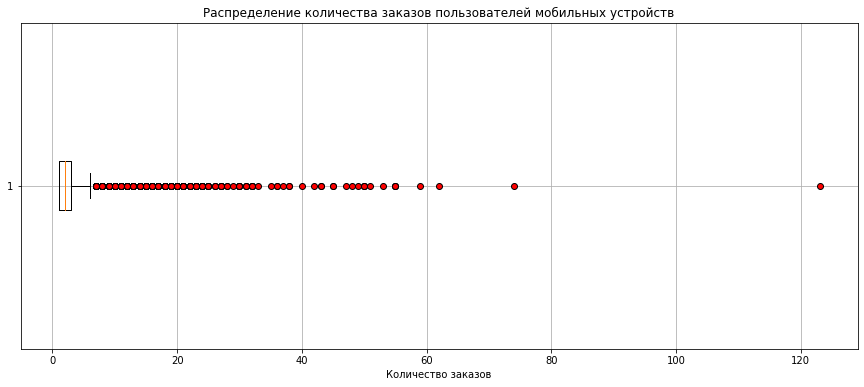

In [121]:
plt.figure(figsize=(15, 6))

plt.boxplot(mobile_orders,
vert=False,
flierprops=dict(markerfacecolor='r', marker='o'))
plt.title('Распределение количества заказов пользователей мобильных устройств')
plt.xlabel('Количество заказов')
plt.grid(True)

plt.show()

На графике заметно большое количество аномально больших выбросов с основой данных в районе 2 заказов.

In [122]:
# найдем 99 процентиль
outline_mobile_orders = mobile_orders.quantile(0.99)
outline_mobile_orders

20.0

In [123]:
outline_mobile_orders_count = mobile_orders.loc[mobile_orders >= outline_mobile_orders].shape[0]
outline_mobile_orders_count

111

111 наблюдений находятся за пределами 99 процентиля, удалим эти выбросы для более качественных данных:

In [124]:
mobile_orders = mobile_orders.loc[mobile_orders < outline_mobile_orders]

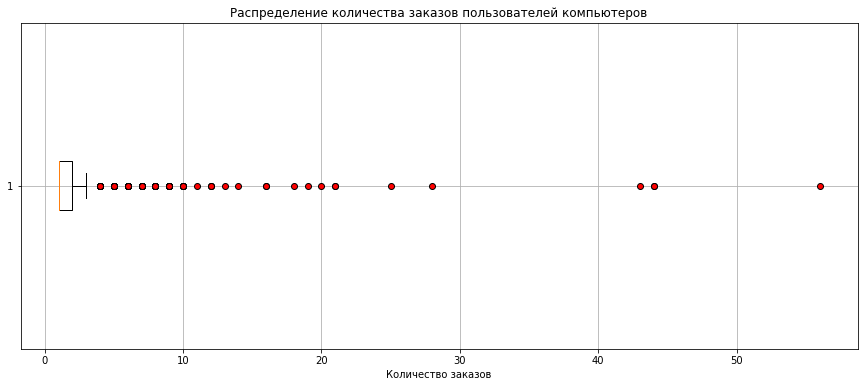

In [125]:
plt.figure(figsize=(15, 6))

plt.boxplot(desktop_orders,
vert=False,
flierprops=dict(markerfacecolor='r', marker='o'))
plt.title('Распределение количества заказов пользователей компьютеров')
plt.xlabel('Количество заказов')
plt.grid(True)

plt.show()

Для `desktop_orders` ситуация схожа, рассмотрим 99 процентиль:

In [126]:
outline_desktop_orders = desktop_orders.quantile(0.99)
outline_desktop_orders

12.0

In [127]:
outline_desktop_orders_count = desktop_orders.loc[desktop_orders >= outline_desktop_orders].shape[0]
outline_desktop_orders_count

18

18 наблюдений находятся за пределами 99 процентиля, удалим эти выбросы для более качественных данных:

In [128]:
desktop_orders = desktop_orders.loc[desktop_orders < outline_desktop_orders]

Посмотрим на статистические параметры отчищенных от выбросов данных:

In [129]:
mobile_orders.describe()

count    10821.000000
mean         2.574439
std          2.643048
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: order_id, dtype: float64

In [130]:
desktop_orders.describe()

count    1602.000000
mean        1.725343
std         1.406497
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        11.000000
Name: order_id, dtype: float64

In [131]:
# Снова проверим дисперсии отчищенных выборок:
print(f'Дисперсия выборки mobile_orders: {mobile_orders.var()}')
print(f'Дисперсия выборки desktop_orders: {desktop_orders.var()}')
print(f'Разница дисперсий: {abs(mobile_orders.var() - desktop_orders.var())}')

Дисперсия выборки mobile_orders: 6.985701452351583
Дисперсия выборки desktop_orders: 1.9782330175974596
Разница дисперсий: 5.007468434754123


Так как разница дисперсий довольно ощутимая в качестве статистического теста для проверки гипотез используем тест Уэлча:

**Н0**: Среднее количество заказов пользователей, использующих мобильное, устройство **не больше** , чем у пользователей, использующих компьютер.

**Н1** : Среднее количество заказов у пользователей, использующих мобильное, устройство **больше**, чем у пользователей, использующих компьютер.

Уровень значимости теста: **5%**

In [132]:
stat_welch_ttest_orders, p_value_welch_ttest_orders = st.ttest_ind(mobile_orders, desktop_orders, equal_var=False, 
                                                                   alternative='greater' )

alpha = 0.05

if p_value_welch_ttest_orders > alpha:
    print(f'pvalue={p_value_welch_ttest_orders} > {alpha}')
    print('Нулевая гипотеза находит подтверждение')
else:
    print(f'pvalue={p_value_welch_ttest_orders} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения')

pvalue=1.7823606560972624e-81 < 0.05
Нулевая гипотеза не находит подтверждения


t-тест Уэлча отверг нулевую гипотезу, значит среднее количество заказов пользователей мобильных устройств больше, чем у пользователей компьютеров, и данное различие статистически значимо.

**Рассмотрим среднее время между заказами пользователей:**

Для начала исключим из анализа данные, в которых отсутсвтует информация о времени между заказами с индикатором `-1`:

In [133]:
df_mobile_time = df_mobile[df_mobile['days_since_prev'] != -1]
df_desktop_time = df_desktop[df_desktop['days_since_prev'] != -1]
print(f'Количество данных для мобильных устройств: {df_mobile_time.shape[0]}')
print(f'Количество данных для компьютеров: {df_desktop_time.shape[0]}')

Количество данных для мобильных устройств: 24553
Количество данных для компьютеров: 2079


In [134]:
mobile_time = df_mobile_time['days_since_prev']
desktop_time = df_desktop_time['days_since_prev']

In [135]:
# Проверим дисперсии выборок:
print(f'Дисперсия выборки mobile_time: {mobile_time.var()}')
print(f'Дисперсия выборки desktop_time: {desktop_time.var()}')
print(f'Разница дисперсий: {abs(mobile_time.var() - desktop_time.var())}')

Дисперсия выборки mobile_time: 661.372871520831
Дисперсия выборки desktop_time: 1066.8730996661698
Разница дисперсий: 405.5002281453387


Проверим распределение и выбросы:

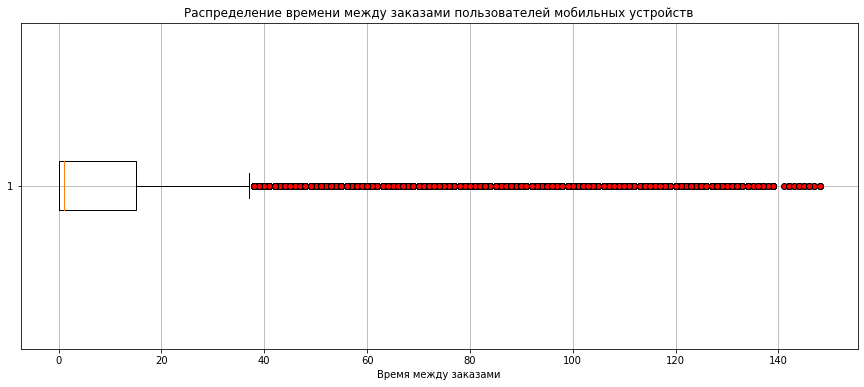

In [136]:
plt.figure(figsize=(15, 6))

plt.boxplot(mobile_time,
vert=False,
flierprops=dict(markerfacecolor='r', marker='o'))
plt.title('Распределение времени между заказами пользователей мобильных устройств')
plt.xlabel('Время между заказами')
plt.grid(True)

plt.show()

In [137]:
outline_mobile_time = mobile_time.quantile(0.99)
outline_mobile_time

116.0

In [138]:
outline_mobile_time_count = mobile_time.loc[mobile_time >= outline_mobile_time].shape[0]
outline_mobile_time_count

251

251 наблюдение находится за 99 процентиелем, удалим эти данные:

In [139]:
mobile_time = mobile_time.loc[mobile_time < outline_mobile_time]

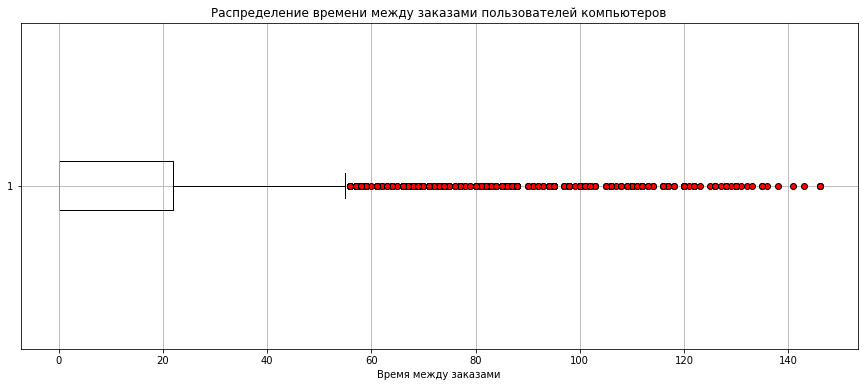

In [140]:
plt.figure(figsize=(15, 6))

plt.boxplot(desktop_time,
vert=False,
flierprops=dict(markerfacecolor='r', marker='o'))
plt.title('Распределение времени между заказами пользователей компьютеров')
plt.xlabel('Время между заказами')
plt.grid(True)

plt.show()

In [141]:
outline_desktop_time = desktop_time.quantile(0.99)
outline_desktop_time

128.0

In [142]:
outline_desktop_time_count = desktop_time.loc[desktop_time >= outline_desktop_time].shape[0]
outline_desktop_time_count

22

22 наблюдения находится за 99 процентиелем, удалим эти данные:

In [143]:
desktop_time = desktop_time.loc[desktop_time < outline_desktop_time]

Посмотрим на статистические параметры отчищенных от выбросов данных:

In [144]:
mobile_time.describe()

count    24302.000000
mean        12.617439
std         23.082316
min          0.000000
25%          0.000000
50%          1.000000
75%         14.000000
max        115.000000
Name: days_since_prev, dtype: float64

In [145]:
desktop_time.describe()

count    2057.000000
mean       16.825960
std        30.527924
min         0.000000
25%         0.000000
50%         0.000000
75%        21.000000
max       127.000000
Name: days_since_prev, dtype: float64

In [146]:
# Снова проверим дисперсии отчищенных выборок:
print(f'Дисперсия выборки mobile_time: {mobile_time.var()}')
print(f'Дисперсия выборки desktop_time: {desktop_time.var()}')
print(f'Разница дисперсий: {abs(mobile_time.var() - desktop_time.var())}')

Дисперсия выборки mobile_time: 532.7933142420787
Дисперсия выборки desktop_time: 931.9541311910173
Разница дисперсий: 399.16081694893853


Так как разница дисперсий большая в качестве статистического теста для проверки гипотез используем тест Уэлча:

**Н0**: Среднее время между заказами пользователей, использующих мобильное устройство, **не больше**, чем у пользователей, использующих компьютер.

**Н1** : Среднее время между зкаказами у пользователей, использующих мобильное устройство, **больше**, чем у пользователей, использующих компьютер.

Уровень значимости теста: **5%**

In [147]:
stat_welch_ttest_time, p_value_welch_ttest_time = st.ttest_ind(mobile_time, desktop_time, equal_var=False, 
                                                                   alternative='greater' )

alpha = 0.05

if p_value_welch_ttest_time > alpha:
    print(f'pvalue={p_value_welch_ttest_time} > {alpha}')
    print('Нулевая гипотеза находит подтверждение')
else:
    print(f'pvalue={p_value_welch_ttest_time} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения')

pvalue=0.9999999994020532 > 0.05
Нулевая гипотеза находит подтверждение


В результате t-теста Уэлча можно сделать вывод о том, что нулевая гипотеза не отвергнута и статистически значимой разницы во времени между заказами у рассматриваемых групп нет.

####  Промежуточный вывод:

Было проведено 2 t-теста Уэлча со следующими результатами:
- **Гипотеза** о том, что **среднее количество заказов пользователей мобильных устройств больше**, чем у пользователей компьютеров, **подтвердилась** с уровнем значимости 5%
- **Гипотеза** о том, что **среднее время между заказами пользователей мобильных устройств больше**, чем у пользователей компьютеров, **не нашла подтверждения** с уровнем значимости 5%.

### Шаг 5. Общий вывод и рекомендации

1. **Общий обзор работы:** В ходе проведенного исследования была проанализирована информация о работе приложения Яндекс Афиша во временной период **июнь 2024 - октябрь 2024**. Детально была рассмотрена информация в разрезе типа мероприятия, типа используемого пользователем устройства, возрастного ограничения мероприятия, проанализировано количество заказов, средняя выручка с заказов. Отдельно рассмотрен осенний период с выявлением цикличности данных, анализом регионов и партнеров. Проведен статистический тест на различие между данными групп пользователей мобильных устройств и компьютеров.

Данные для анализа представляли собой три датасета с информацией о заказах в приложении, о мероприятиях и о курсе валют (тенге к рублю).

**На первом этапе работы удалось провести предобработку данных.**

- Данные были переведены в соответствующий формат и тип для анализа.
- Данные были отчищены от выбросов и дубликатов.
- Было создано значение-индикатор для более качественного анализа.
- Были созданы новые переменные.

**На втором этапе работы был проведен исследовательский анализ данных (в т.ч. проверка гипотез), который включал в себя:**

- анализ распределения заказов по сегментам;
- анализ осенней активности пользователей;
- анализ популярных событий и партнеров.

2. **Ответы на исследовательские вопросы:**
- Распределение заказов по сегментам:
  -  Присутствует тренд на увеличение количества заказов, тренд усиливается в осенний сезон.
  - Основу данных в каждом месяце занимают такие типы мероприятий как `концерты`, `театр` и `другое`. Осенью, по сравнению с летом доля типа `театр` и `спорт` значительно возрасли.
  - Распредленеие по девайсам стабильно представлено соотношением **80/20** для `телефонов` и `компьютеров` соответственно.
  - Мероприятия `0+` стали более популяны ближе к осени, а мероприятия `18+` наоборот стали менее популярны. Основу данных стабильно занимают мероприятия `16+`.
  - В разрезе типов мероприятий к осени значительно снизилась средняя выручка за один билет с мероприятий типа `концерты`, `театр` и `ёлки`, немного возрасла средняя выручка с типов `выставки` и `стендап`.
  - Осенью по сравнению с летом самый большой рост доли количества заказов показали мероприятия типа `спорт` (увеличение на 8.7 п.п.), а самое большое снижение доли тип `другое` (падение на 7.5 п.п.),общая доля мероприятий с возрастным ограничением `0+` увеличилась, в то время как доля мероприятий `18+` упала.

- Осенняя активность пользователей:
  - За исследуемые два месяца осени (`Сентябрь` и `Октябрь`) заметен общий тренд на постепенное увеличение количества заказов и пользователей с сильной волатильностью по дням недели. Пиковые значения количества заказов приходятся на начало месяцев, в частности два раза на `Вторник` и один раз на `Четверг`. 
  - Рассматривая динамику по дням недели, стоит отметить пиковые значения количества заказов во `Вторник` и `Четверг`, после которого показатель постепенно снижается к `Воскресенью`. Количество пользователей принимает максимальное значение в `Четверг` и также постепенно снижается к `Воскресенью`.
  - Самыми непопулярными днями в приложении являются `Воскресенье` и `Понедельник`.
  - Влияние резкого снижения средней выручки с одного билета во `Вторник` можно объяснить тем, что количество купленных билетов в этот день максимальное, а общая выручка не максимальна.
  
- Популярные события и партнеры:
  - В разрезе регионов с довольно большим отрывом лидирует `Каменевский регион` с **31.3%** от общего числа заказов и **26.6%** проведенных уникальных мероприятий от всего списка.
  - Также в ТОП-3 входят `Североярская область` и `Широковская область` с долями заказов **15.2% и 5.6%** соответственно.
  - **ТОП-10** регионов составляют **72%** от всех заказов в исследуемых данных.
  - В разрезе партнеров в лидеры можно выделить `Билеты без проблем` с **16.3%** от общей выручки и **21.8%** от общего количества заказов. Также можно выделить партнеров `Мой билет`, `Лови билет!` и `Облачко`.
  - **ТОП-5** партнеров занимают **65.6%** в общей выручке за рассматриваемый период.

3. **Резуьтаты статистических тестов:** Тесты смогли подвердить гипотезу о том, что среднее количество заказов пользователей мобильных устройств больше, чем у пользователей компьютеров, однако не смогли подвердить гипотезу о том, что среднее время между заказами пользователей мобильных устройств больше, чем у пользователей компьютеров.

4. В качестве **рекомендаций** можно выделить следующие моменты:
- Стоит активно поддерживать и увеличивать рекламные кампании во вторник и четверг, так как на эти дни приходится большая часть пользователей и заказов, также предпочтение лучше отдать рекламе на мобильных устройствах из-за непопулярности компьютеров для пользования приложением.
- Однако не стоит концентрироваться только на увеличении количества купленных билетов, так как выручка приложения зависит и от других факторов, максимальное количество билетов не будет делать максимальную выручку.
- `Каменевский регион` и `Североярская область` выделяются самыми большими долями по числу заказов, стоит развивать инфраструктуру приложения в оставшихся регионов из ТОП-10, так как на данный момент они составляют 72% от общего числа заказов.
- В качестве дальнейших переспектив исследования можно предложить более детально проанализировать связь выручки со всеми показателями, чтобы выяснить наиболее влиятельные факторы и потенциальные точки роста.